This is the first notebook. It provides an overview to the full dataset. It contains many countries and many columns. Generally, it shows why we selected our 5 countries.

# 1. First look at dataset

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from pmdarima.arima.utils import ndiffs, nsdiffs
from utils.descriptive_analysis import plot_missings, plot_seasonality, hist_plots, corr_plot, count_outliers
from utils.stationarity import stationary_seasonal, granger_causality

from itertools import permutations


import warnings
warnings.filterwarnings('ignore')

# TODO: delete cet_cest_timestamp
# TODO 1: Only plot for training data
# TODO 2: Perform tests only on train data

data = pd.read_csv('./datasets/time_series_60min_singleindex.csv')

# Prepare date column
data = data.rename(columns={'utc_timestamp': 'date'}
                   ).drop(['cet_cest_timestamp'], axis=1)

data['date'] = pd.to_datetime(data['date'])

data.head()

date  AT_load_actual_entsoe_transparency  \
0 2014-12-31 23:00:00+00:00                                 NaN   
1 2015-01-01 00:00:00+00:00                              5946.0   
2 2015-01-01 01:00:00+00:00                              5726.0   
3 2015-01-01 02:00:00+00:00                              5347.0   
4 2015-01-01 03:00:00+00:00                              5249.0   

   AT_solar_generation_actual  AT_wind_onshore_generation_actual  \
0                         NaN                                NaN   
1                         NaN                               69.0   
2                         NaN                               64.0   
3                         NaN                               65.0   
4                         NaN                               64.0   

   BE_load_actual_entsoe_transparency  BE_solar_generation_actual  \
0                                 NaN                         NaN   
1                              9484.0                         NaN   
2                              9152.0                         NaN   
3                              8799.0                         NaN   
4                              8567.0                         NaN   

   BE_wind_generation_actual  BE_wind_offshore_generation_actual  \
0                        NaN                                 NaN   
1                        NaN                                 NaN   
2                     734.81                              518.66   
3                     766.64                              529.46   
4                     733.13                              406.94   

   BE_wind_onshore_generation_actual  BG_load_actual_entsoe_transparency  ...  \
0                                NaN                                 NaN  ...   
1                                NaN                                 NaN  ...   
2                             216.15                              4585.0  ...   
3                             237.18                              4440.0  ...   
4                             326.19                              4418.0  ...   

   SE_3_wind_onshore_generation_actual  SE_4_load_actual_entsoe_transparency  \
0                                  NaN                                   NaN   
1                                  NaN                                   NaN   
2                                  NaN                                2281.0   
3                                  NaN                                2313.0   
4                                  NaN                                2372.0   

   SE_4_wind_onshore_generation_actual  SI_load_actual_entsoe_transparency  \
0                                  NaN                                 NaN   
1                                  NaN                                 NaN   
2                                  NaN                             1045.47   
3                                  NaN                             1004.79   
4                                  NaN                              983.79   

   SI_solar_generation_actual  SI_wind_onshore_generation_actual  \
0                         NaN                                NaN   
1                         NaN                                NaN   
2                         NaN                               1.17   
3                         NaN                               1.04   
4                         NaN                               1.61   

   SK_load_actual_entsoe_transparency  SK_solar_generation_actual  \
0                                 NaN                         NaN   
1                                 NaN                         NaN   
2                              2728.0                         3.8   
3                              2626.0                         3.8   
4                              2618.0                         3.8   

   SK_wind_onshore_generation_actual  UA_load_actual_entsoe_transparency  
0                                NaN               

Count columns that contain word load, solar and wind.
Wind has the biggest number of columns, because it is divided into offshore and onshore.
However, not all countries have offshore wind generation.

In [2]:
cols_load = [col for col in data.columns if 'load' in col]
cols_solar = [col for col in data.columns if 'solar' in col]
cols_wind = [col for col in data.columns if 'wind' in col]
print(f'Number of load columns: {len(cols_load)}\nNumber of solar columns: {len(cols_solar)}\nNumber of wind columns: {len(cols_wind)}')

Number of load columns: 57
Number of solar columns: 39
Number of wind columns: 82


List of countries that contain onshore and offshore generation.
They are then summed up to the "total wind generation".

In [3]:
cols_wind_generation = [col for col in cols_wind if 'wind_generation' in col]
cols_wind_generation

['BE_wind_generation_actual',
 'DE_wind_generation_actual',
 'DE_50hertz_wind_generation_actual',
 'DE_LU_wind_generation_actual',
 'DE_tennet_wind_generation_actual',
 'DK_wind_generation_actual',
 'DK_1_wind_generation_actual',
 'DK_2_wind_generation_actual',
 'GB_GBN_wind_generation_actual',
 'GB_UKM_wind_generation_actual',
 'NL_wind_generation_actual',
 'PT_wind_generation_actual']

In [4]:
# So, they reported as total generation only columns that have onshore and offshore generation
cols_wind_offshore_generation = [col for col in cols_wind if 'wind_offshore_generation' in col]
cols_wind_offshore_generation

['BE_wind_offshore_generation_actual',
 'DE_wind_offshore_generation_actual',
 'DE_50hertz_wind_offshore_generation_actual',
 'DE_LU_wind_offshore_generation_actual',
 'DE_tennet_wind_offshore_generation_actual',
 'DK_wind_offshore_generation_actual',
 'DK_1_wind_offshore_generation_actual',
 'DK_2_wind_offshore_generation_actual',
 'GB_GBN_wind_offshore_generation_actual',
 'GB_UKM_wind_offshore_generation_actual',
 'NL_wind_offshore_generation_actual',
 'PT_wind_offshore_generation_actual']

Calculate how many mismatches between sum of offshore and onshore, and their respective "total" wind generation.

In [5]:
check_sums = ['BE', 'DE', 'DE_50hertz', 'DE_LU', 'DE_tennet', 'DK_1', 'DK_2', 'GB_GBN', 'GB_UKM', 'NL', 'PT']

num_mismatch_sum = 0

for area in check_sums:
    offshore_col = f"{area}_wind_offshore_generation_actual"
    onshore_col = f"{area}_wind_onshore_generation_actual"
    generation_col = f"{area}_wind_generation_actual"

    # Check for missing values in offshore_col and onshore_col
    non_missing_values = (~data[offshore_col].isnull() & ~data[onshore_col].isnull())
    
    # Check whether the sum of offshore_col and onshore_col equals generation_col only when both are non-missing
    mismatch_condition = (((data[offshore_col] + data[onshore_col]).round(2) != data[generation_col]) & non_missing_values)
    
    # Count the number of mismatches
    num_mismatch = mismatch_condition.sum()
    
    print(f"Number of mismatches for {area}: {num_mismatch}")
    num_mismatch_sum += num_mismatch

print(f"Total number of rows where the sum is not equal: {num_mismatch_sum}")


Number of mismatches for BE: 303
Number of mismatches for DE: 12591
Number of mismatches for DE_50hertz: 11832
Number of mismatches for DE_LU: 4341
Number of mismatches for DE_tennet: 12822
Number of mismatches for DK_1: 6
Number of mismatches for DK_2: 10
Number of mismatches for GB_GBN: 13890
Number of mismatches for GB_UKM: 12509
Number of mismatches for NL: 11766
Number of mismatches for PT: 0
Total number of rows where the sum is not equal: 80070


Max difference between sum of onshore and offshore, and their respective "total" wind generation column.

In [6]:
from numpy.testing import assert_almost_equal

# Iterate over each area
for area in check_sums:
    offshore_col = f"{area}_wind_offshore_generation_actual"
    onshore_col = f"{area}_wind_onshore_generation_actual"
    generation_col = f"{area}_wind_generation_actual"
    
    # Filter the DataFrame based on non-missing values in both offshore and onshore columns
    non_missing_values = ~data[[offshore_col, onshore_col]].isnull().any(axis=1)
    filtered_data = data[non_missing_values]
    
    # Calculate the sum of offshore and onshore columns
    sum_offshore_onshore = filtered_data[offshore_col] + filtered_data[onshore_col]
    
    # Calculate the difference between the sum of offshore and onshore and generation columns
    diff = sum_offshore_onshore - filtered_data[generation_col]

    print(f'Max difference for {area}:', diff.max())
    print(f'Min difference for {area}:', diff.min())
    
    # Assert that the difference is almost equal to zero
    # assert_almost_equal(diff.values, 0)

Max difference for BE: 3.000195647473447e-09
Min difference for BE: -2.9999682737980038e-09
Max difference for DE: 1.0
Min difference for DE: -69.0
Max difference for DE_50hertz: 1.0
Min difference for DE_50hertz: -1.0
Max difference for DE_LU: 1.0
Min difference for DE_LU: -1.0
Max difference for DE_tennet: 1.0
Min difference for DE_tennet: -1.0
Max difference for DK_1: 2.9999682737980038e-09
Min difference for DK_1: -2.9999682737980038e-09
Max difference for DK_2: 1.0001031114370562e-09
Min difference for DK_2: -1.0001031114370562e-09
Max difference for GB_GBN: 1.0
Min difference for GB_GBN: -1.0
Max difference for GB_UKM: 10.0
Min difference for GB_UKM: -1.0
Max difference for NL: 1.0
Min difference for NL: -1.0
Max difference for PT: 4.547473508864641e-13
Min difference for PT: -4.547473508864641e-13


 Check, maximum missing values (in offshore or onshore) with "total" wind generation missing. 
 They are the same (except GB_UKM).

In [7]:
for area in check_sums:
    max_missing = max(data[f"{area}_wind_offshore_generation_actual"].isna().sum(), data[f"{area}_wind_onshore_generation_actual"].isna().sum())
    ready_col = data[f"{area}_wind_generation_actual"].isnull().sum()
    print(f"{area} max missing in offshore or onshore: {max_missing}, total col: {ready_col}")

BE max missing in offshore or onshore: 3935, total col: 3935
DE max missing in offshore or onshore: 75, total col: 75
DE_50hertz max missing in offshore or onshore: 1, total col: 1
DE_LU max missing in offshore or onshore: 32855, total col: 32855
DE_tennet max missing in offshore or onshore: 1, total col: 1
DK_1 max missing in offshore or onshore: 3, total col: 3
DK_2 max missing in offshore or onshore: 3, total col: 3
GB_GBN max missing in offshore or onshore: 41, total col: 41
GB_UKM max missing in offshore or onshore: 128, total col: 129
NL max missing in offshore or onshore: 1967, total col: 1967
PT max missing in offshore or onshore: 47509, total col: 47509


# 2. Analysis of countries and zones in dataset

In [8]:
data_areas = pd.read_csv('./datasets/areas.csv')
data_areas.head()

area ID ISO 3166-1 alpha-2 MapCode ENTSO-E primary AreaName ENTSO-E  \
0      AT                 AT              AT                  Austria   
1      BA                 BA             NaN                      NaN   
2      BE                 BE              BE                  Belgium   
3      BG                 BG              BG                 Bulgaria   
4      CH                 CH              CH              Switzerland   

  primary concept  EU memberstate  EU inside  15min  30min 60min  ...  \
0         country            True       True   True  False  True  ...   
1         country           False      False  False  False  True  ...   
2         country            True       True  False  False  True  ...   
3         country            True       True  False  False  True  ...   
4         country           False      False  False  False  True  ...   

  control area market balance area load from ENTSO-E TP  \
0          APG                 APG                 True   
1      NOS BiH             NOS BiH                False   
2         Elia                Elia                 True   
3          ESO                 ESO                 True   
4    swissgrid           swissgrid                 True   

  generation from ENTSOE-TP price from ENTSO-E TP generation from TSO  \
0                      True                  True                True   
1                     False                 False               False   
2                      True                 False               False   
3                      True                 False               False   
4                      True                 False               False   

  price from TSO  load from ENTSO-E data portal  load from TSO  \
0          False                           True          False   
1          False                           True          False   
2          False                           True          False   
3          False                           True          False   
4          False                           True          False   

   Capacity from OPSD  
0               False  
1               False  
2               False  
3               False  
4               False  

[5 rows x 25 columns]

The dataset contains the data on countries level, as well as other levels.

In [9]:
data_areas['primary concept'].unique()

array(['country', 'control area', 'bidding zone', 'region',
       'market balance area', 'bidding zone aggregation'], dtype=object)

82 unique area IDs in the dataset.

In [10]:
len(data_areas['area ID'].unique())

82

Check the ENTSO-E areas and their IDs.

In [11]:
data_areas_filtered = data_areas.query('`primary concept`=="country" and `primary AreaName ENTSO-E`.notnull()')[['area ID', 'primary AreaName ENTSO-E']].reset_index(drop=True)
data_areas_filtered

area ID               primary AreaName ENTSO-E
0       AT                                Austria
1       BE                                Belgium
2       BG                               Bulgaria
3       CH                            Switzerland
4       CY                                 Cyprus
5       CZ                         Czech Republic
6       DE                                Germany
7       DK                                Denmark
8       EE                                Estonia
9       ES                                  Spain
10      FI                                Finland
11      FR                                 France
12  GB_UKM                         United Kingdom
13  GB_GBN                       National Grid BZ
14  GB_NIR                                SONI CA
15      GR                                 Greece
16      HR                                Croatia
17      HU                                Hungary
18      IE                                Ireland
19      IT                                  Italy
20      LT                              Lithuania
21      LU                             Luxembourg
22      LV                                 Latvia
23      ME                             Montenegro
24      MK  Former Yugoslav Republic of Macedonia
25      NL                            Netherlands
26      NO                                 Norway
27      PL                                 Poland
28      PT                               Portugal
29      RO                                Romania
30      RS                                 Serbia
31      SE                                 Sweden
32      SI                               Slovenia
33      SK                               Slovakia
34      MT                                  Malta
35      UA                                Ukraine

In [12]:
# Query that does not exclude Luxembourg, UA and MT
data_filter = data_areas.query(
    '(`primary concept`!="country" \
      or `primary AreaName ENTSO-E`.isnull()) \
      and `area ID`.notnull()')['area ID'].unique()
data_filter

array(['BA', 'CS', 'DE_50hertz', 'DE_amprion', 'DE_tennet',
       'DE_transnetbw', 'DE_AT_LU', 'DK_1', 'DK_2', 'DK_energinet',
       'GB_EAW', 'GB_SCT', 'IE_sem', 'IS', 'IT_BRNN', 'IT_CNOR',
       'IT_CSUD', 'IT_FOGN', 'IT_GR', 'IT_NORD', 'IT_NORD_AT',
       'IT_NORD_CH', 'IT_NORD_FR', 'IT_NORD_SI', 'IT_PRGP', 'IT_ROSN',
       'IT_SACO_AC', 'IT_SACO_DC', 'IT_SARD', 'IT_SICI', 'IT_SUD', 'NO_1',
       'NO_2', 'NO_3', 'NO_4', 'NO_5', 'SE_1', 'SE_2', 'SE_3', 'SE_4',
       'AL', 'DE_LU', 'TR', 'UA_west', 'UA_east'], dtype=object)

In [13]:
# exclude non-countries
v_to_delete = ['GB_NIR', 'GB_GBN']

# to keep ttrack of countries in dataset
data_areas_filtered = data_areas_filtered[~data_areas_filtered['area ID'].isin(v_to_delete)].reset_index(drop=True)
data_filter = np.append(data_filter, v_to_delete) 

In [14]:
columnVals = data.columns.map(lambda x: x.startswith(tuple(data_filter)))
filtered_data = data.loc[:, ~columnVals].copy()

In [15]:
filtered_data.head()

date  AT_load_actual_entsoe_transparency  \
0 2014-12-31 23:00:00+00:00                                 NaN   
1 2015-01-01 00:00:00+00:00                              5946.0   
2 2015-01-01 01:00:00+00:00                              5726.0   
3 2015-01-01 02:00:00+00:00                              5347.0   
4 2015-01-01 03:00:00+00:00                              5249.0   

   AT_solar_generation_actual  AT_wind_onshore_generation_actual  \
0                         NaN                                NaN   
1                         NaN                               69.0   
2                         NaN                               64.0   
3                         NaN                               65.0   
4                         NaN                               64.0   

   BE_load_actual_entsoe_transparency  BE_solar_generation_actual  \
0                                 NaN                         NaN   
1                              9484.0                         NaN   
2                              9152.0                         NaN   
3                              8799.0                         NaN   
4                              8567.0                         NaN   

   BE_wind_generation_actual  BE_wind_offshore_generation_actual  \
0                        NaN                                 NaN   
1                        NaN                                 NaN   
2                     734.81                              518.66   
3                     766.64                              529.46   
4                     733.13                              406.94   

   BE_wind_onshore_generation_actual  BG_load_actual_entsoe_transparency  ...  \
0                                NaN                                 NaN  ...   
1                                NaN                                 NaN  ...   
2                             216.15                              4585.0  ...   
3                             237.18                              4440.0  ...   
4                             326.19                              4418.0  ...   

   RS_load_actual_entsoe_transparency  SE_load_actual_entsoe_transparency  \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2                                 NaN                             14485.0   
3                                 NaN                             14298.0   
4                                 NaN                             14249.0   

   SE_wind_onshore_generation_actual  SI_load_actual_entsoe_transparency  \
0                                NaN                                 NaN   
1                                NaN                                 NaN   
2                                NaN                             1045.47   
3                                NaN                             1004.79   
4                                NaN                              983.79   

   SI_solar_generation_actual  SI_wind_onshore_generation_actual  \
0                         NaN                                NaN   
1                         NaN                                NaN   
2                         NaN                               1.17   
3                         NaN                               1.04   
4                         NaN                               1.61   

   SK_load_actual_entsoe_transparency  SK_solar_generation_actual  \
0                                 NaN                         NaN   
1                                 NaN                         NaN   
2                              2728.0                         3.8   
3                              2626.0                         3.8   
4                              2618.0                         3.8   

   SK_wind_onshore_generation_actual  UA_load_actual_entsoe_transparency  
0                                NaN                                 NaN  
1     

How many countries have wind_generation and offshore generation columns?

In [16]:
[col for col in filtered_data.columns if 'wind_generation' in col]

['BE_wind_generation_actual',
 'DE_wind_generation_actual',
 'DK_wind_generation_actual',
 'GB_UKM_wind_generation_actual',
 'NL_wind_generation_actual',
 'PT_wind_generation_actual']

In [17]:
[col for col in filtered_data.columns if 'wind_offshore_generation' in col]

['BE_wind_offshore_generation_actual',
 'DE_wind_offshore_generation_actual',
 'DK_wind_offshore_generation_actual',
 'GB_UKM_wind_offshore_generation_actual',
 'NL_wind_offshore_generation_actual',
 'PT_wind_offshore_generation_actual']

# 3. Missing values Analysis

## 3.1 Filter countries by number of missing values.

1. We saw earlier that not all the countries have offshore generation, but just few of them.

From the dataset we can see that Portugal has 94% of missings in those columns, leaving us with small period of observations.
Therefore, we can exclude analysis of these columns in Portugal.

2. As we can see, HR(Croatia) has almost 100% missing values in solar and wind_onshore columns. -> Exclude this country from analysis.

We can also exclude Poland, Hungary, Slovakia, Montenegro, Ukraine and Cyprus, because they have more than 30% of missings.

3. We want to have "consistent" countries, in other words, with the same columns and same time period.

In general, this part just shows the logic we followed to select the countries for our analysis.

In [18]:
# Missing values
missing_values = filtered_data.isnull()

# Calculate percentage of missing values in each column
percentage_missing = (missing_values.sum() / len(filtered_data)) * 100

# Print or inspect the percentage of missing values
print(percentage_missing[percentage_missing >= 30].sort_values(ascending=False))


HR_solar_generation_actual            99.980159
HR_wind_onshore_generation_actual     99.956350
PT_wind_generation_actual             94.262019
PT_wind_offshore_generation_actual    94.262019
PL_solar_generation_actual            91.738259
HU_solar_generation_actual            82.212655
SK_wind_onshore_generation_actual     80.796016
ME_wind_onshore_generation_actual     59.405567
UA_load_actual_entsoe_transparency    49.137914
CY_load_actual_entsoe_transparency    34.662011
dtype: float64


In [19]:
percentage_missing[percentage_missing >= 30].count()

10

In [20]:
v_to_delete = ['HR', 'PL', 'HU', 'SK', 'ME', 'UA', 'CY']

# to keep ttrack of countries in dataset
data_areas_filtered = data_areas_filtered[~data_areas_filtered['area ID'].isin(v_to_delete)].reset_index(drop=True)
columnVals = filtered_data.columns.map(lambda x: x.startswith(tuple(v_to_delete)))
filtered_data = filtered_data.loc[:, ~columnVals].copy()

In [21]:
filtered_data.head()

date  AT_load_actual_entsoe_transparency  \
0 2014-12-31 23:00:00+00:00                                 NaN   
1 2015-01-01 00:00:00+00:00                              5946.0   
2 2015-01-01 01:00:00+00:00                              5726.0   
3 2015-01-01 02:00:00+00:00                              5347.0   
4 2015-01-01 03:00:00+00:00                              5249.0   

   AT_solar_generation_actual  AT_wind_onshore_generation_actual  \
0                         NaN                                NaN   
1                         NaN                               69.0   
2                         NaN                               64.0   
3                         NaN                               65.0   
4                         NaN                               64.0   

   BE_load_actual_entsoe_transparency  BE_solar_generation_actual  \
0                                 NaN                         NaN   
1                              9484.0                         NaN   
2                              9152.0                         NaN   
3                              8799.0                         NaN   
4                              8567.0                         NaN   

   BE_wind_generation_actual  BE_wind_offshore_generation_actual  \
0                        NaN                                 NaN   
1                        NaN                                 NaN   
2                     734.81                              518.66   
3                     766.64                              529.46   
4                     733.13                              406.94   

   BE_wind_onshore_generation_actual  BG_load_actual_entsoe_transparency  ...  \
0                                NaN                                 NaN  ...   
1                                NaN                                 NaN  ...   
2                             216.15                              4585.0  ...   
3                             237.18                              4440.0  ...   
4                             326.19                              4418.0  ...   

   PT_wind_onshore_generation_actual  RO_load_actual_entsoe_transparency  \
0                                NaN                                 NaN   
1                                NaN                                 NaN   
2                              551.0                                 NaN   
3                              596.5                                 NaN   
4                              706.3                                 NaN   

   RO_solar_generation_actual  RO_wind_onshore_generation_actual  \
0                         NaN                                NaN   
1                         NaN                                NaN   
2                         NaN                                NaN   
3                         NaN                                NaN   
4                         NaN                                NaN   

   RS_load_actual_entsoe_transparency  SE_load_actual_entsoe_transparency  \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2                                 NaN                             14485.0   
3                                 NaN                             14298.0   
4                                 NaN                             14249.0   

   SE_wind_onshore_generation_actual  SI_load_actual_entsoe_transparency  \
0                                NaN                                 NaN   
1                                NaN                                 NaN   
2                                NaN                             1045.47   
3                                NaN                             1004.79   
4                                NaN                              983.79   

   SI_solar_generation_actual  SI_wind_onshore_generation_actual  
0                         NaN                  

In [22]:
# remove PT wind_generation, PT wind_offshore_generation columns 
filtered_data = filtered_data.drop(columns=['PT_wind_generation_actual', 'PT_wind_offshore_generation_actual'])

27 countries left.

In [23]:
data_areas_filtered

area ID               primary AreaName ENTSO-E
0       AT                                Austria
1       BE                                Belgium
2       BG                               Bulgaria
3       CH                            Switzerland
4       CZ                         Czech Republic
5       DE                                Germany
6       DK                                Denmark
7       EE                                Estonia
8       ES                                  Spain
9       FI                                Finland
10      FR                                 France
11  GB_UKM                         United Kingdom
12      GR                                 Greece
13      IE                                Ireland
14      IT                                  Italy
15      LT                              Lithuania
16      LU                             Luxembourg
17      LV                                 Latvia
18      MK  Former Yugoslav Republic of Macedonia
19      NL                            Netherlands
20      NO                                 Norway
21      PT                               Portugal
22      RO                                Romania
23      RS                                 Serbia
24      SE                                 Sweden
25      SI                               Slovenia
26      MT                                  Malta

In [24]:
cols_load = [col for col in filtered_data.columns if 'load' in col]
cols_solar_generation = [col for col in filtered_data.columns if 'solar' in col]
cols_wind_generation = [col for col in filtered_data.columns if 'wind' in col]
print(f'Number of load columns: {len(cols_load)}\nNumber of solar generation columns: {len(cols_solar_generation)}\nNumber of wind generation columns: {len(cols_wind_generation)}')

Number of load columns: 25
Number of solar generation columns: 18
Number of wind generation columns: 33


# 4. Choose first 5: Germany, Spain, France, Italy, Britain

Wind onshore: Germany, Spain, France, Britain, Italy

Solar: Germany, Italy, Spain, France, Britain

Load: Germany, France, Britain, Italy, Spain

In [25]:
# Only 2019
# Because it is the most recent full year with observations
data_2019 = filtered_data[filtered_data['date'].dt.year == 2019]
wind_onshore = data_2019[[col for col in data_2019.columns if 'wind_onshore_generation' in col]].copy()
wind_onshore.sum(axis=0).sort_values(ascending=False).head()

DE_wind_onshore_generation_actual        99621663.0
ES_wind_onshore_generation_actual        52348168.0
FR_wind_onshore_generation_actual        32697605.0
GB_UKM_wind_onshore_generation_actual    27241553.0
IT_wind_onshore_generation_actual        19937169.0
dtype: float64

In [26]:
solar = data_2019[[col for col in data_2019.columns if 'solar' in col]].copy()
solar.sum(axis=0).sort_values(ascending=False).head()

DE_solar_generation_actual        41914747.0
IT_solar_generation_actual        19084518.0
ES_solar_generation_actual        14421347.0
FR_solar_generation_actual        11420469.0
GB_UKM_solar_generation_actual    11012711.0
dtype: float64

In [27]:
solar = data_2019[[col for col in data_2019.columns if 'load' in col]].copy()
solar.sum(axis=0).sort_values(ascending=False).head()

DE_load_actual_entsoe_transparency        490474666.0
FR_load_actual_entsoe_transparency        467369654.0
GB_UKM_load_actual_entsoe_transparency    303731763.0
IT_load_actual_entsoe_transparency        294149910.0
ES_load_actual_entsoe_transparency        249988215.0
dtype: float64

In [28]:
top_5_countries = ['DE', 'GB', 'ES', 'FR', 'IT']
prefixes_to_keep = [col for col in filtered_data.columns if col.startswith(tuple(top_5_countries))]
prefixes_to_keep.insert(0, 'date')
df_top_5 = filtered_data[prefixes_to_keep].copy()

In [29]:
df_top_5

date  DE_load_actual_entsoe_transparency  \
0     2014-12-31 23:00:00+00:00                                 NaN   
1     2015-01-01 00:00:00+00:00                             41151.0   
2     2015-01-01 01:00:00+00:00                             40135.0   
3     2015-01-01 02:00:00+00:00                             39106.0   
4     2015-01-01 03:00:00+00:00                             38765.0   
...                         ...                                 ...   
50396 2020-09-30 19:00:00+00:00                             57559.0   
50397 2020-09-30 20:00:00+00:00                             54108.0   
50398 2020-09-30 21:00:00+00:00                             49845.0   
50399 2020-09-30 22:00:00+00:00                             46886.0   
50400 2020-09-30 23:00:00+00:00                             45461.0   

       DE_solar_generation_actual  DE_wind_generation_actual  \
0                             NaN                        NaN   
1                             NaN                     8852.0   
2                             NaN                     9054.0   
3                             NaN                     9070.0   
4                             NaN                     9163.0   
...                           ...                        ...   
50396                         0.0                    10654.0   
50397                         0.0                    11836.0   
50398                         0.0                    12168.0   
50399                         0.0                    12533.0   
50400                         0.0                    12798.0   

       DE_wind_offshore_generation_actual  DE_wind_onshore_generation_actual  \
0                                     NaN                                NaN   
1                                   517.0                             8336.0   
2                                   514.0                             8540.0   
3                                   518.0                             8552.0   
4                                   520.0                             8643.0   
...                                   ...                                ...   
50396                              4754.0                             5900.0   
50397                              5194.0                             6642.0   
50398                              5339.0                             6829.0   
50399                              5399.0                             7134.0   
50400                              5381.0                             7417.0   

       ES_load_actual_entsoe_transparency  ES_solar_generation_actual  \
0                                     NaN                         NaN   
1                                     NaN                         NaN   
2                                 22734.0                        50.0   
3                                 21286.0                        50.0   
4                                 20264.0                        42.0   
...                                   ...                         ...   
50396                             30860.0                        29.0   
50397                             27994.0                        21.0   
50398                             25706.0                        21.0   
50399                             24926.0                        22.0   
50400                                 NaN                         NaN   

       ES_wind_onshore_generation_actual  FR_load_actual_entsoe_transparency  \
0                                    NaN                                 NaN   
1                                    NaN                                 NaN   
2                                 5461.0                             69773.0   
3                                 5238.0                             66417.0   
4                                 4935.0                             64182.0   
...                                  ...                                 ...   
50396  

# 5. Analyse top 5 countries

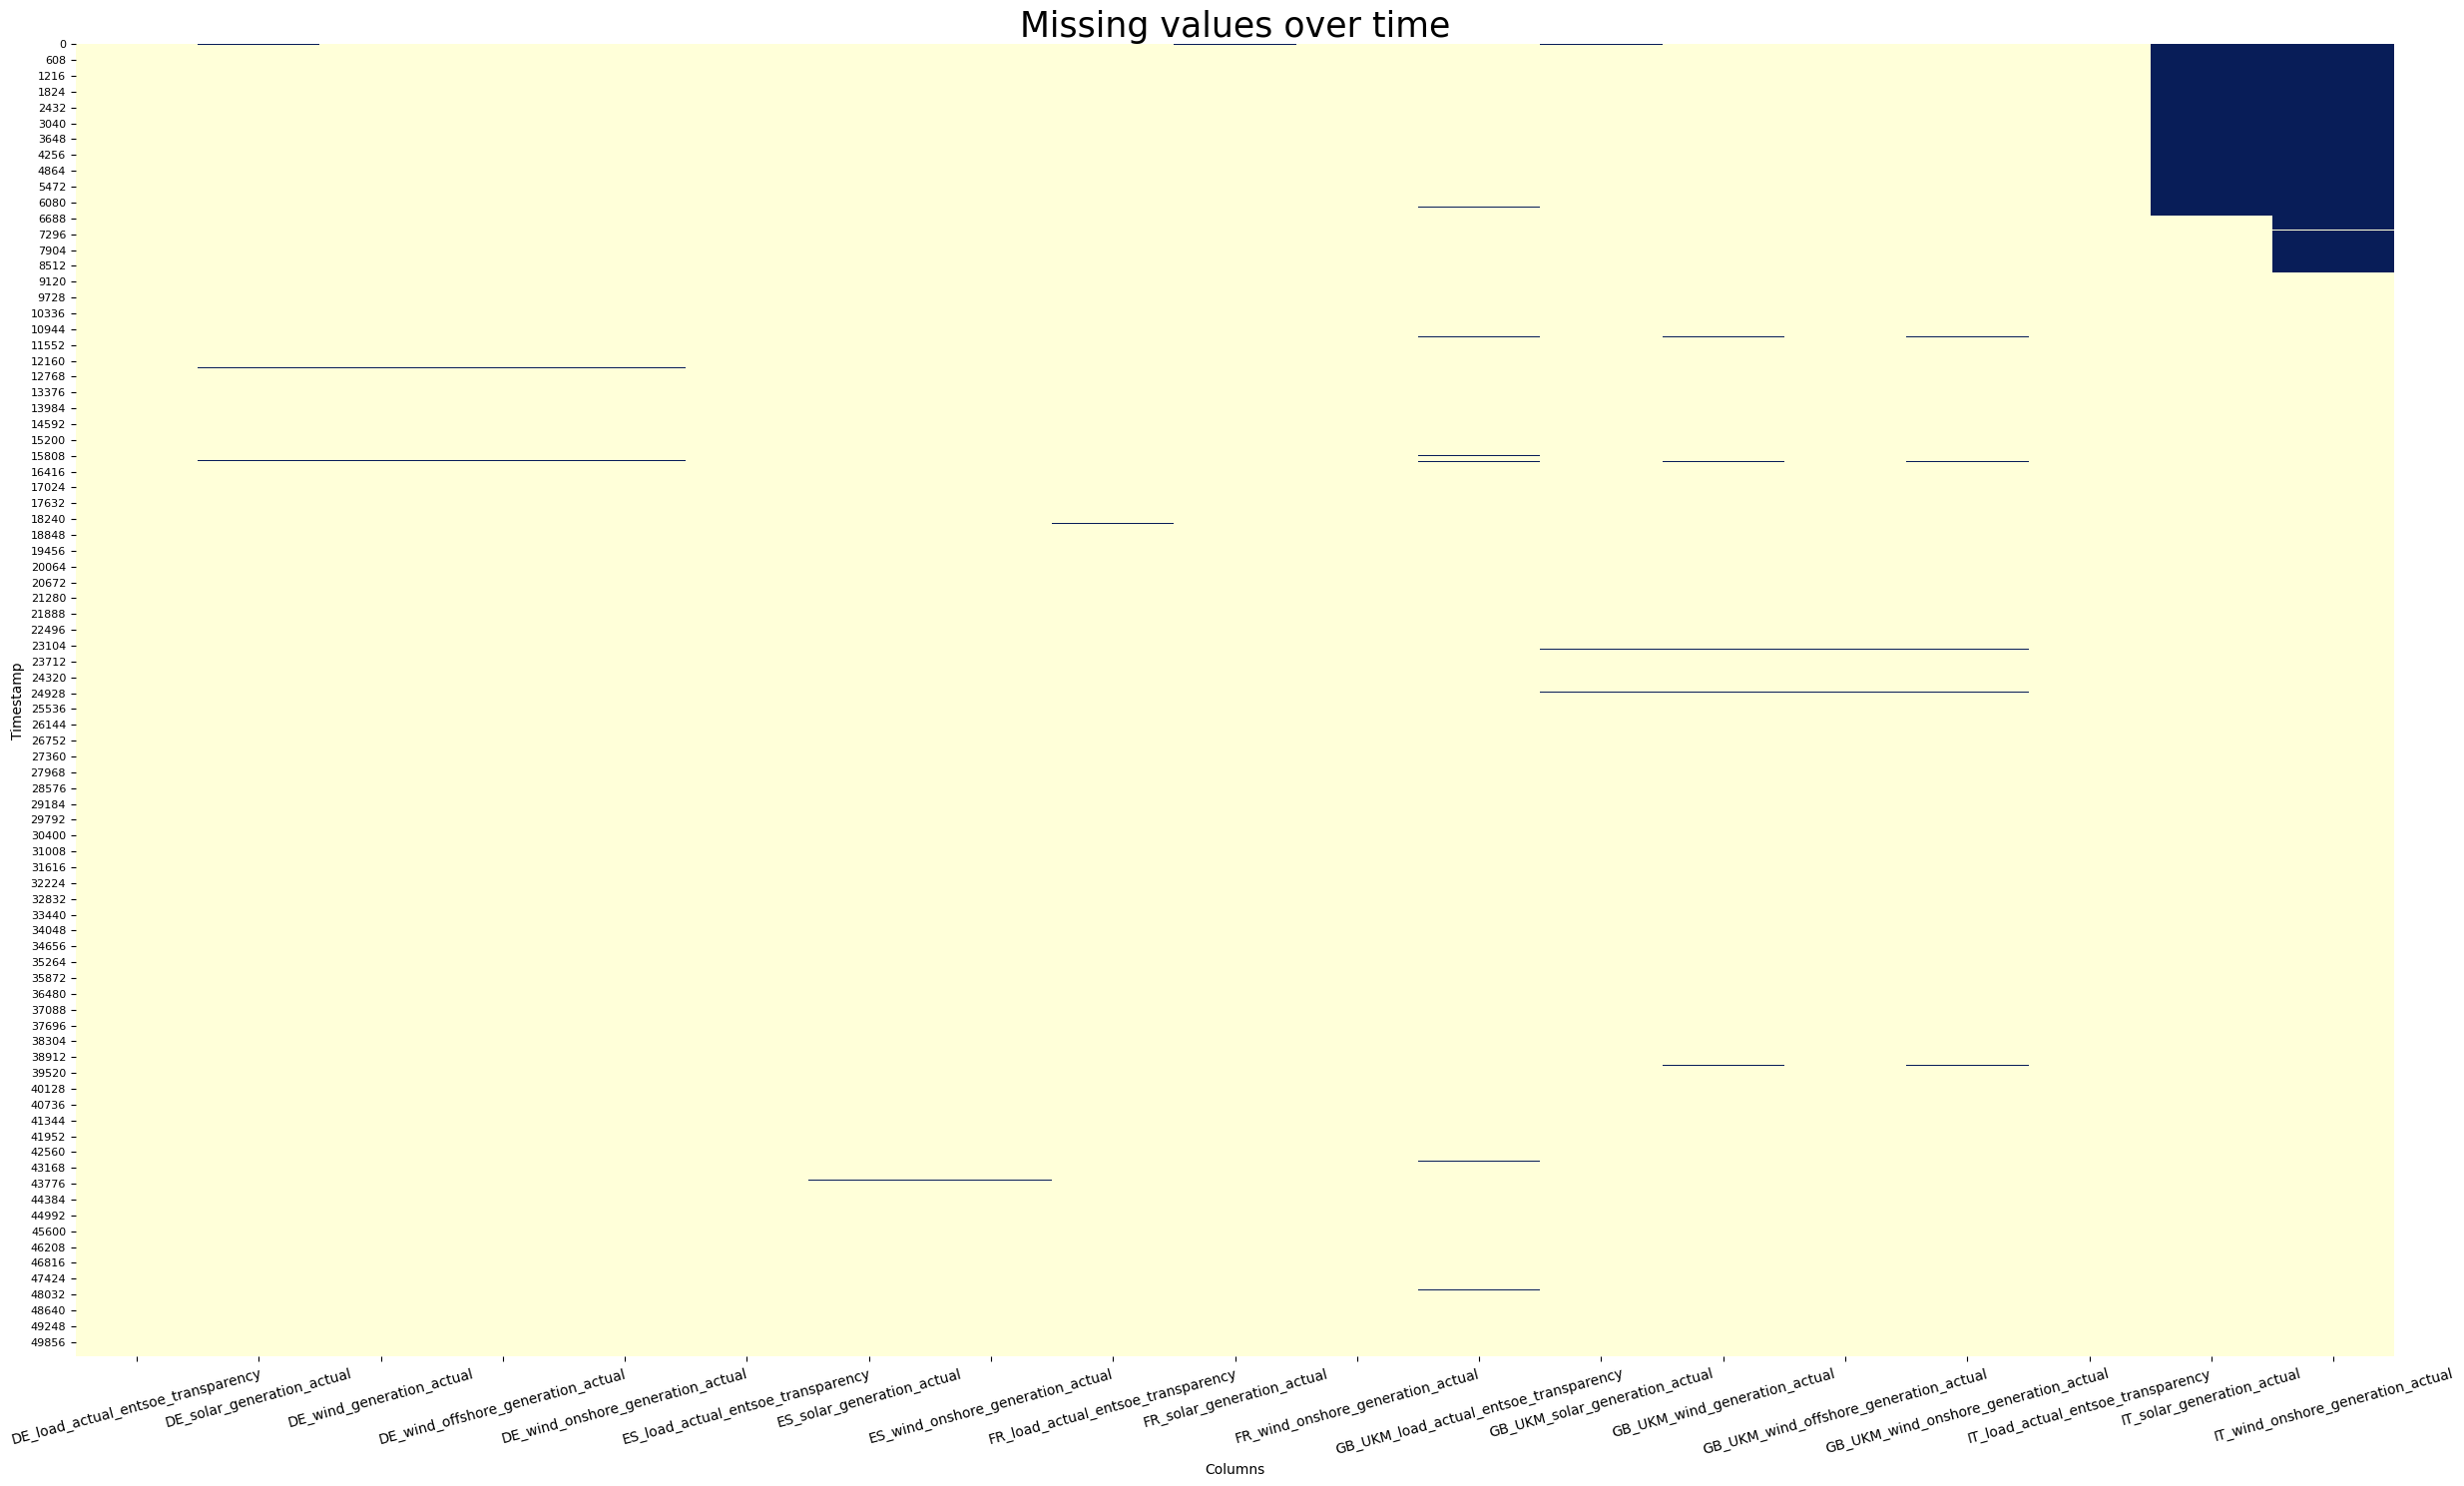

In [30]:
plot_missings(df_top_5.loc[:, df_top_5.columns != 'date'])

Italy has missing values at the start of the dataframe. Since we want to have unified periods, we should drop them.

In [31]:
# drop last day from df, because it is not full for IT solar generation and we cannot impute them later
# Find the last day in the DataFrame
# Please note that dt.date is used to get the date part of the datetime object, namely (year, month, day)
# and removes hours, minutes and seconds
last_day = df_top_5['date'].dt.date.max()

# Drop all observations from the last day
df_top_5 = df_top_5[df_top_5['date'].dt.date < last_day]

# The start of notna data
min_date = df_top_5.loc[df_top_5['IT_wind_onshore_generation_actual'].notna()]['date'].dt.date.min()
df_top_5 = df_top_5[df_top_5['date'].dt.date > min_date]
min_date

datetime.date(2015, 10, 24)

We still have missing values, let's treat them.

In [32]:
# Check for missings again
df_top_5.isna().sum()

date                                         0
DE_load_actual_entsoe_transparency           0
DE_solar_generation_actual                  72
DE_wind_generation_actual                   74
DE_wind_offshore_generation_actual          74
DE_wind_onshore_generation_actual           72
ES_load_actual_entsoe_transparency           3
ES_solar_generation_actual                   8
ES_wind_onshore_generation_actual            8
FR_load_actual_entsoe_transparency          41
FR_solar_generation_actual                   5
FR_wind_onshore_generation_actual            5
GB_UKM_load_actual_entsoe_transparency     163
GB_UKM_solar_generation_actual              32
GB_UKM_wind_generation_actual              119
GB_UKM_wind_offshore_generation_actual      32
GB_UKM_wind_onshore_generation_actual      119
IT_load_actual_entsoe_transparency           0
IT_solar_generation_actual                   9
IT_wind_onshore_generation_actual         1617
dtype: int64

We select the columns with daily seasonality to impute missing values there with the previous day's values at exactly same hour. 
We suppose that such imputation is a better choice here than simple linear extrapolation. For example, for solar generation values at night might be zeroes every day, therefore we should impute such missings with zeroes rather that linearly.

In [33]:
selected_columns = [col for col in df_top_5.columns if 'load' in col or 'solar' in col]

In [34]:
# Impute missing values for Load and Solar with previous day observations at the same time
df_top_5 = df_top_5.set_index('date')
columns_shift = df_top_5[selected_columns].shift(freq='24H')

# Fill missing values with values from the previous day
df_top_5 = df_top_5.fillna(columns_shift)

# Fill wind columns with linear/time interpolation
# In our case it is linear interpolation (because distance between time points is the same)
df_top_5.interpolate(method='time', axis=0, inplace=True) 

In [35]:
df_top_5.isna().sum()

DE_load_actual_entsoe_transparency        0
DE_solar_generation_actual                0
DE_wind_generation_actual                 0
DE_wind_offshore_generation_actual        0
DE_wind_onshore_generation_actual         0
ES_load_actual_entsoe_transparency        0
ES_solar_generation_actual                0
ES_wind_onshore_generation_actual         0
FR_load_actual_entsoe_transparency        0
FR_solar_generation_actual                0
FR_wind_onshore_generation_actual         0
GB_UKM_load_actual_entsoe_transparency    0
GB_UKM_solar_generation_actual            0
GB_UKM_wind_generation_actual             2
GB_UKM_wind_offshore_generation_actual    0
GB_UKM_wind_onshore_generation_actual     2
IT_load_actual_entsoe_transparency        0
IT_solar_generation_actual                0
IT_wind_onshore_generation_actual         0
dtype: int64

In [36]:
# delete first day, because of the remaining missing values
min_date = df_top_5.index.date.min()
df_top_5 = df_top_5[df_top_5.index.date > min_date]

# 6. Visual Analysis of Time Series

In [37]:
# Extract year and month from the index
df_top_5.loc[:, 'DayOfWeek'] = df_top_5.index.dayofweek
df_top_5.loc[:, 'DayOfMonth'] = df_top_5.index.day
df_top_5.loc[:, 'Year'] = df_top_5.index.year
df_top_5.loc[:, 'Month'] = df_top_5.index.month
df_top_5['HourOfDay'] = df_top_5.index.hour
df_top_5['WeekOfYear'] = df_top_5.index.isocalendar().week

Please note that we have lots of zero values in solar generation. Almost all countries have 25%-th quantile with 0. 
We need this observation further for choice of evaluation metrics. Some of them (e. g. SMAPE) do not tolerate zero values.

In [38]:
df_top_5.describe()

DE_load_actual_entsoe_transparency  DE_solar_generation_actual  \
count                        43224.000000                43224.000000   
mean                         55695.863872                 4564.355775   
std                          10053.824476                 7018.889758   
min                          31307.000000                    0.000000   
25%                          47310.750000                    0.000000   
50%                          55285.000000                  136.000000   
75%                          64489.250000                 7199.250000   
max                          77549.000000                32947.000000   

       DE_wind_generation_actual  DE_wind_offshore_generation_actual  \
count               43224.000000                        43224.000000   
mean                12214.258491                         2176.620882   
std                  9303.691487                         1579.725297   
min                   135.000000                            0.000000   
25%                  4927.000000                          767.000000   
50%                  9733.500000                         2003.000000   
75%                 17119.000000                         3322.000000   
max                 46064.000000                         6901.000000   

       DE_wind_onshore_generation_actual  ES_load_actual_entsoe_transparency  \
count                       43224.000000                        43224.000000   
mean                        10037.634277                        28435.537410   
std                          8186.809831                         4618.096318   
min                           119.000000                        16575.000000   
25%                          3771.120000                        24586.750000   
50%                          7627.000000                        28494.000000   
75%                         13934.250000                        32036.000000   
max                         40752.000000                        41015.000000   

       ES_solar_generation_actual  ES_wind_onshore_generation_actual  \
count                43224.000000                       43224.000000   
mean                  1615.229699                        5561.726217   
std                   2001.406163                        3272.242983   
min                      0.000000                           0.000000   
25%                     63.000000                        3005.750000   
50%                    620.000000                        4916.000000   
75%                   2860.000000                        7509.000000   
max                   9338.000000                       17343.000000   

       FR_load_actual_entsoe_transparency  FR_solar_generation_actual  ...  \
count                        43224.000000                43224.000000  ...   
mean                         53315.477512                 1145.900113  ...   
std                          11651.221093                 1611.355788  ...   
min                          29398.000000                    0.000000  ...   
25%                          44411.500000                    0.000000  ...   
50%                          51665.000000                  154.500000  ...   
75%                          61352.000000                 2028.000000  ...   
max                         158000.000000                 7417.000000  ...   

       GB_UKM_wind_onshore_generation_actual  \
count                           43224.000000   
mean                             3003.719404   
std                              1793.048378   
min                               143.000000   
25%                              1490.000000   
50%                              2692.000000   
75%                              4289.000000   
max                              9048.000000   

       IT_load_actual_entsoe_transparency  IT_solar_generation_actual  \
count                        43224.000000                43224.000000   
mean                         32862.980335       

Expectedly, here is a yearly seasonality in the time series. 
For example, load: at winter months - more consumption (because days are shorter, it is cold - more heating is needed).
Also at winter is more windy - more wind generation and less sunny - less solar generation.

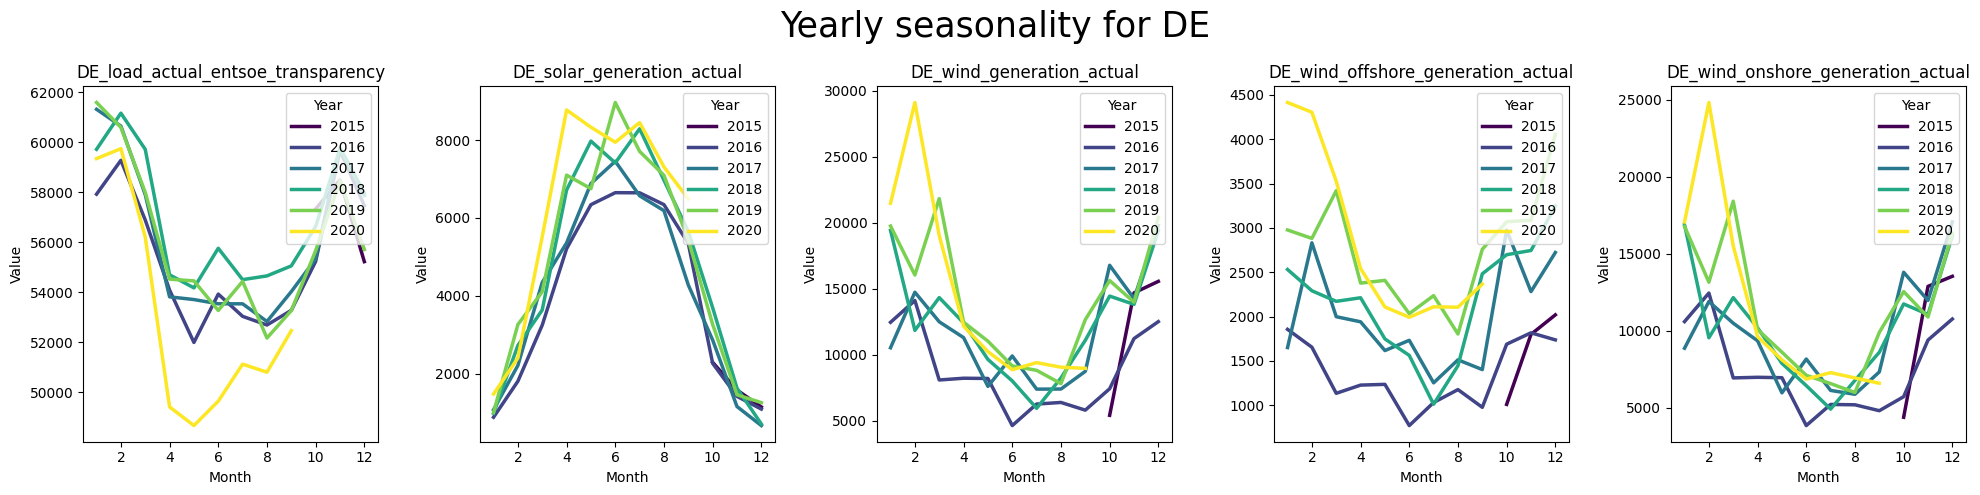

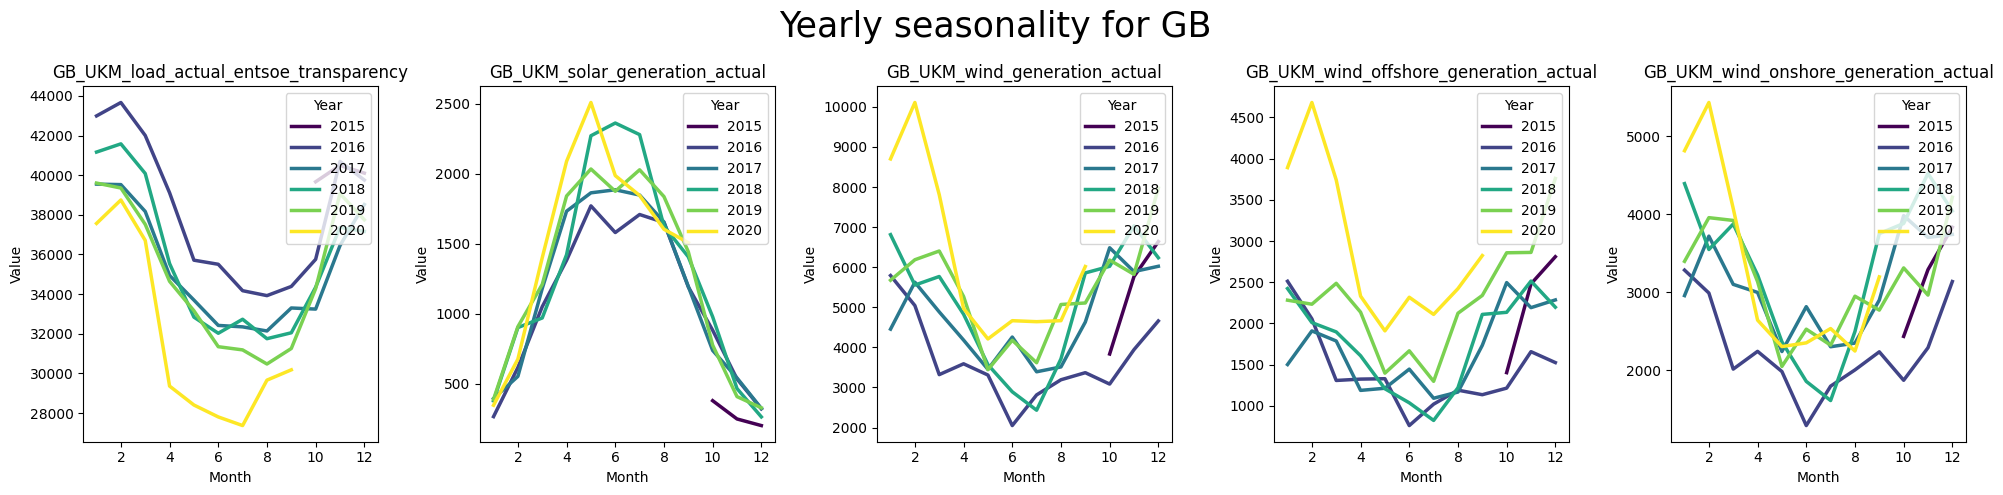

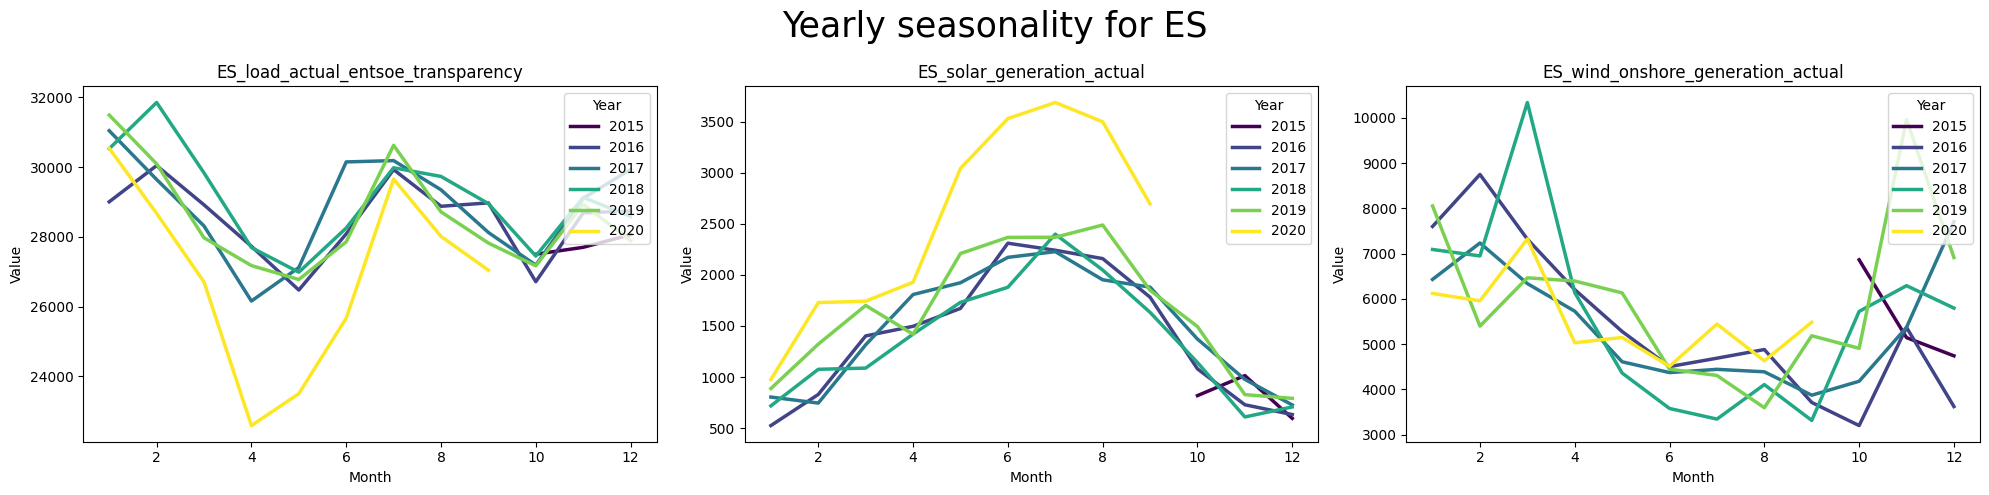

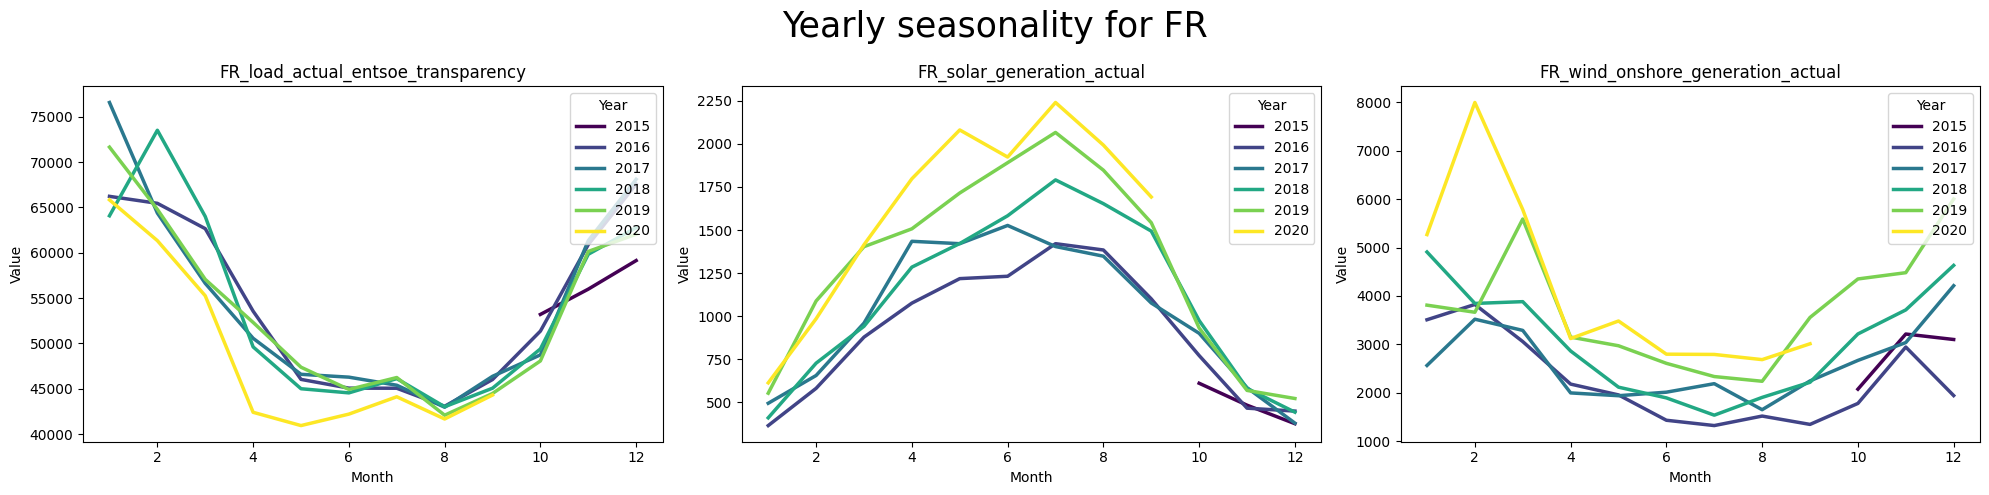

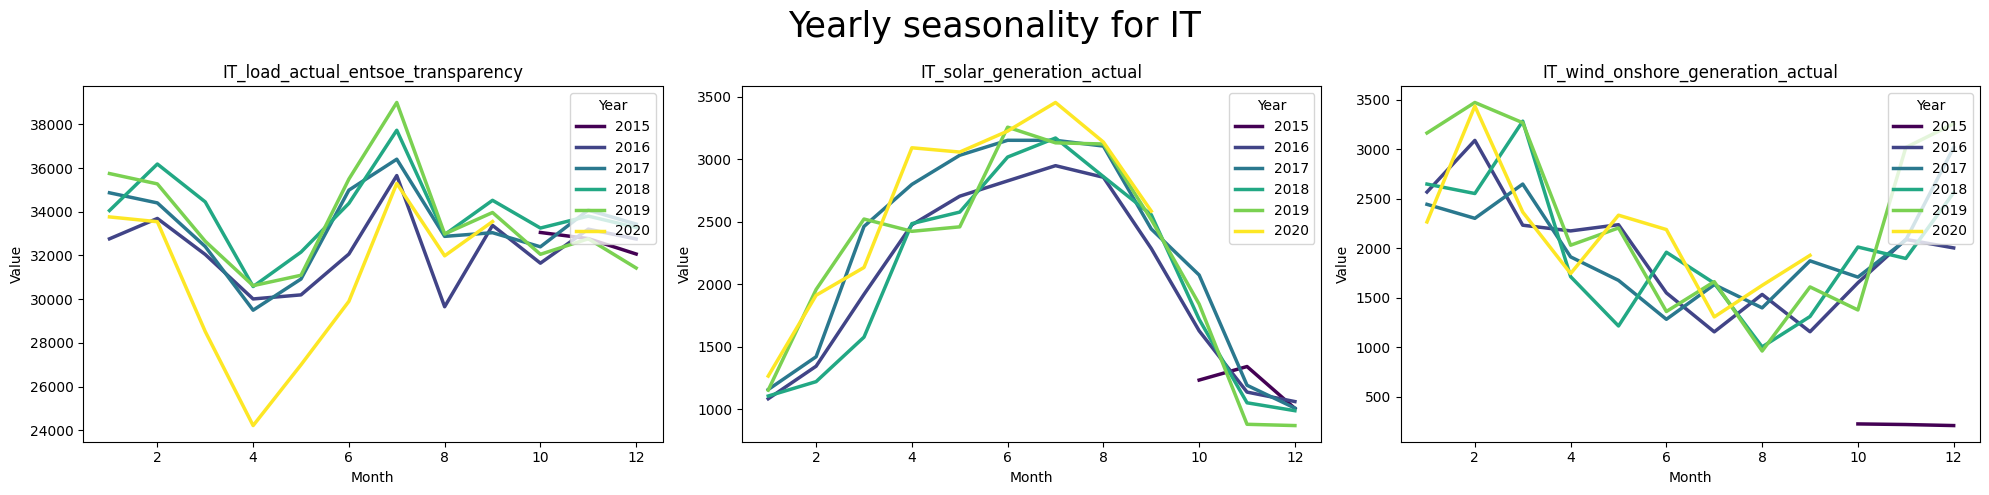

In [39]:
top_5_countries = ['DE', 'GB', 'ES', 'FR', 'IT']

for col in top_5_countries:

    data = df_top_5.filter(like=col, axis=1)

    n_cols = len(data.columns)

    # append cols with date infos
    data = pd.concat([data, df_top_5.iloc[:, -6:]], axis=1)

    plot_seasonality(data = data, 
                     num_cols=n_cols, 
                     title=f'Yearly seasonality for {col}')

There is, for example, a clear increasing trend on solar and wind generation in every year. For example in Germany, France and Britain. More capacities installed, more renewable energy is generated.

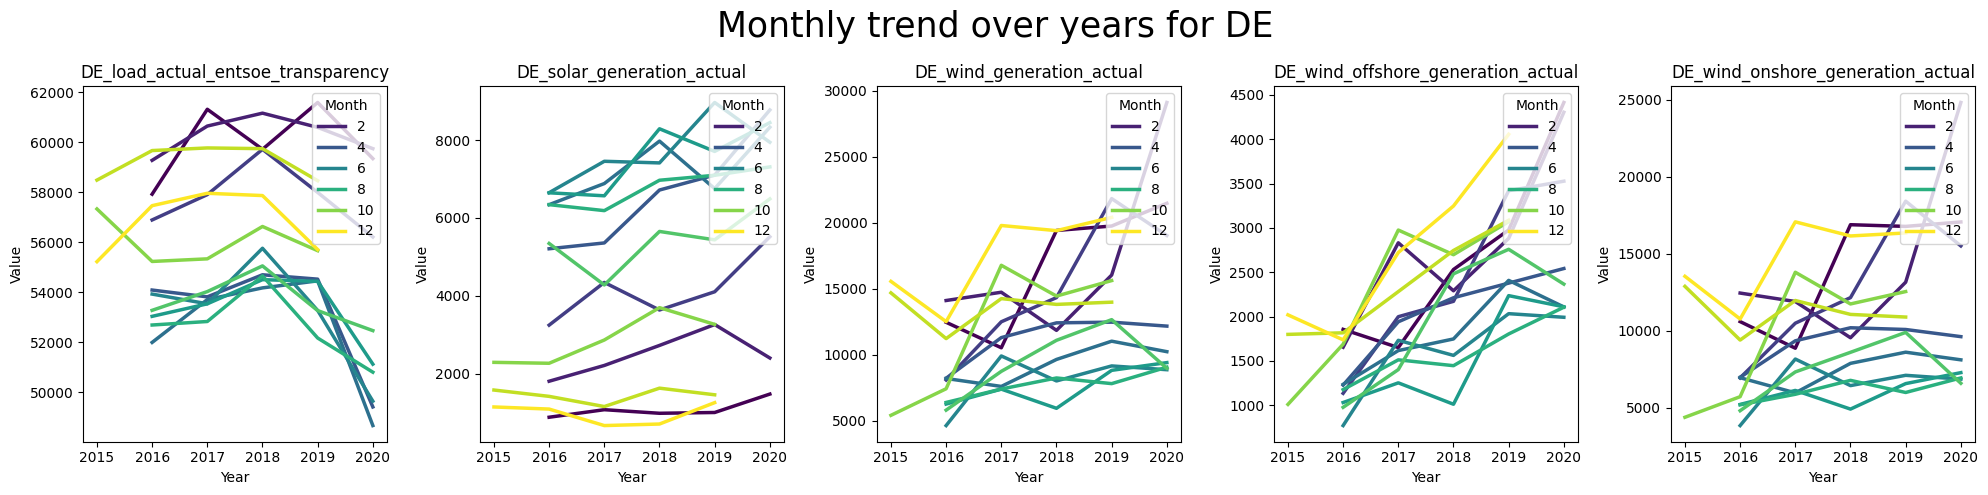

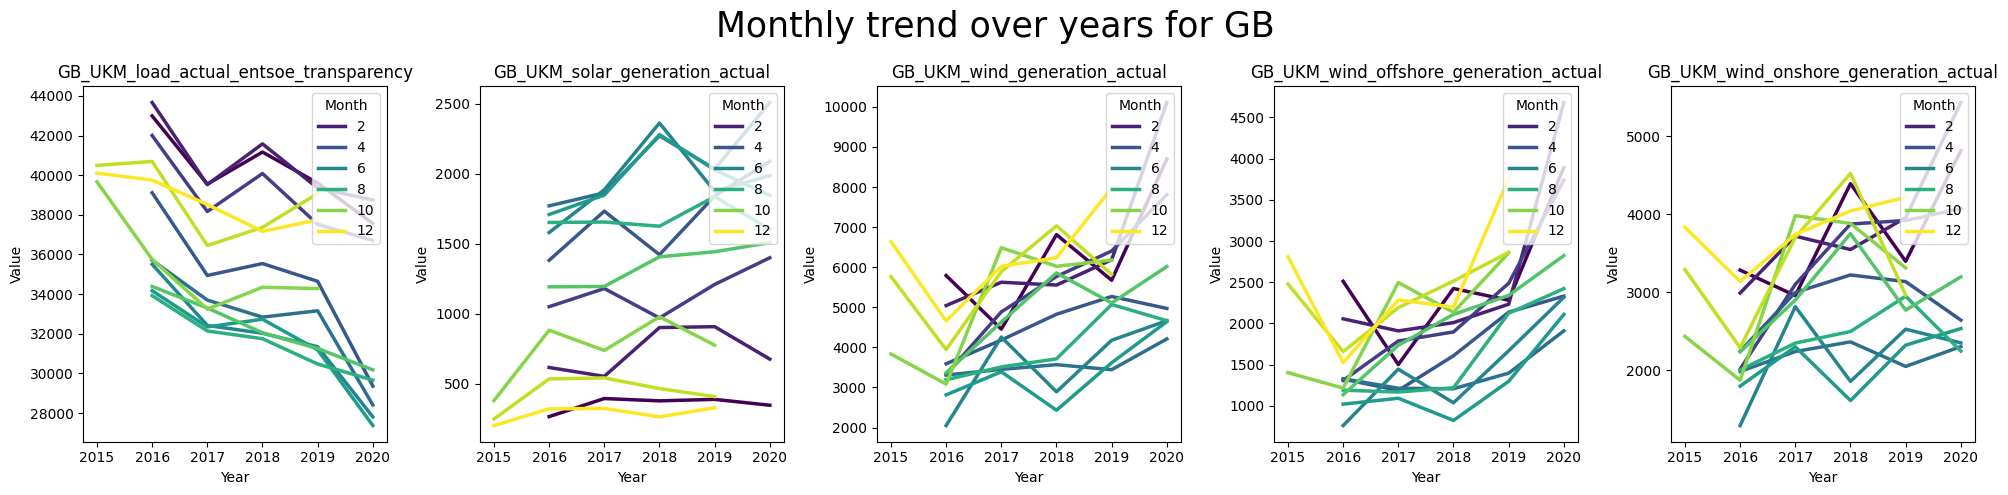

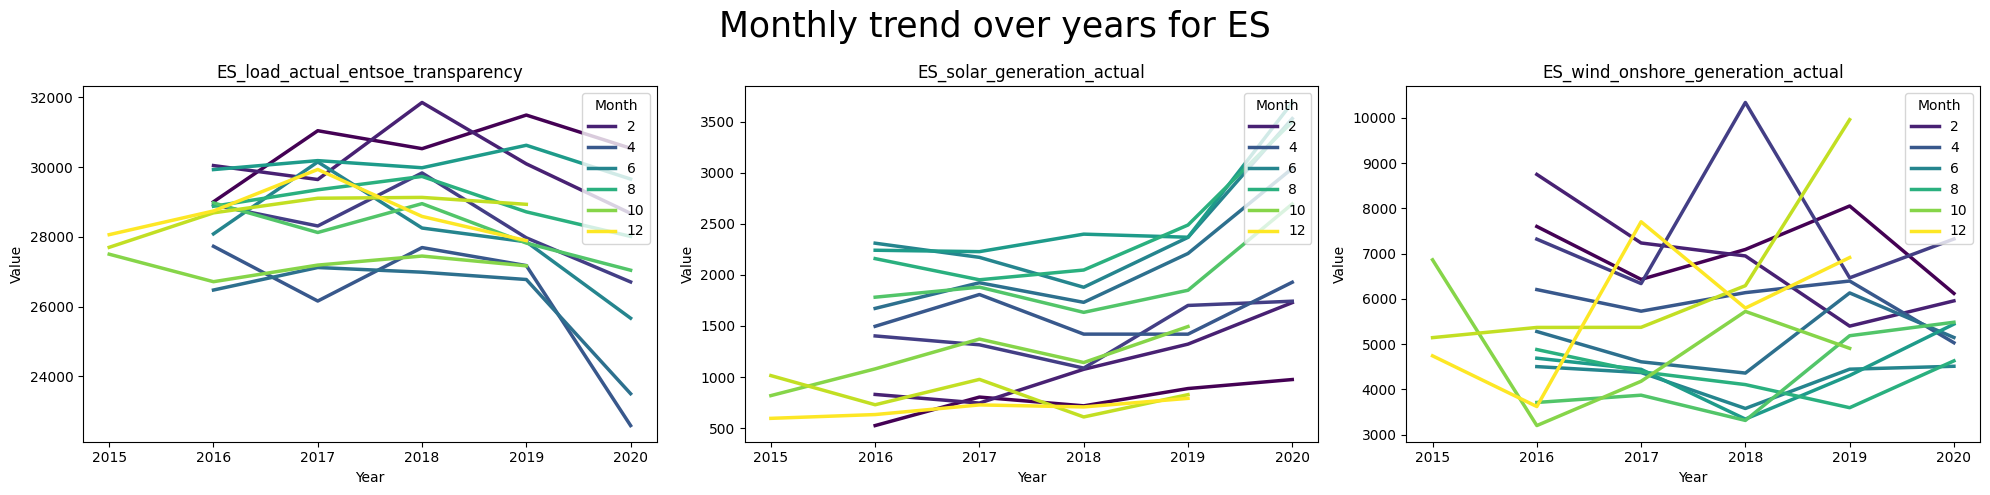

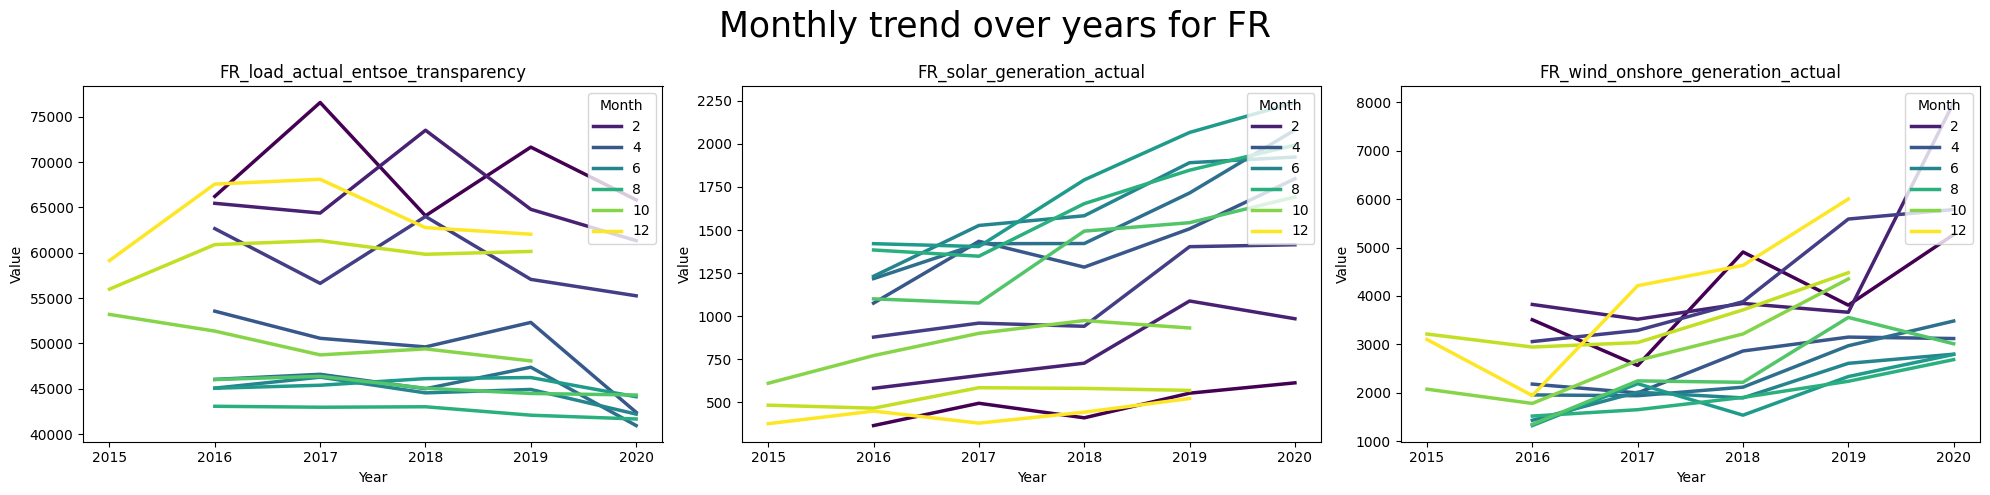

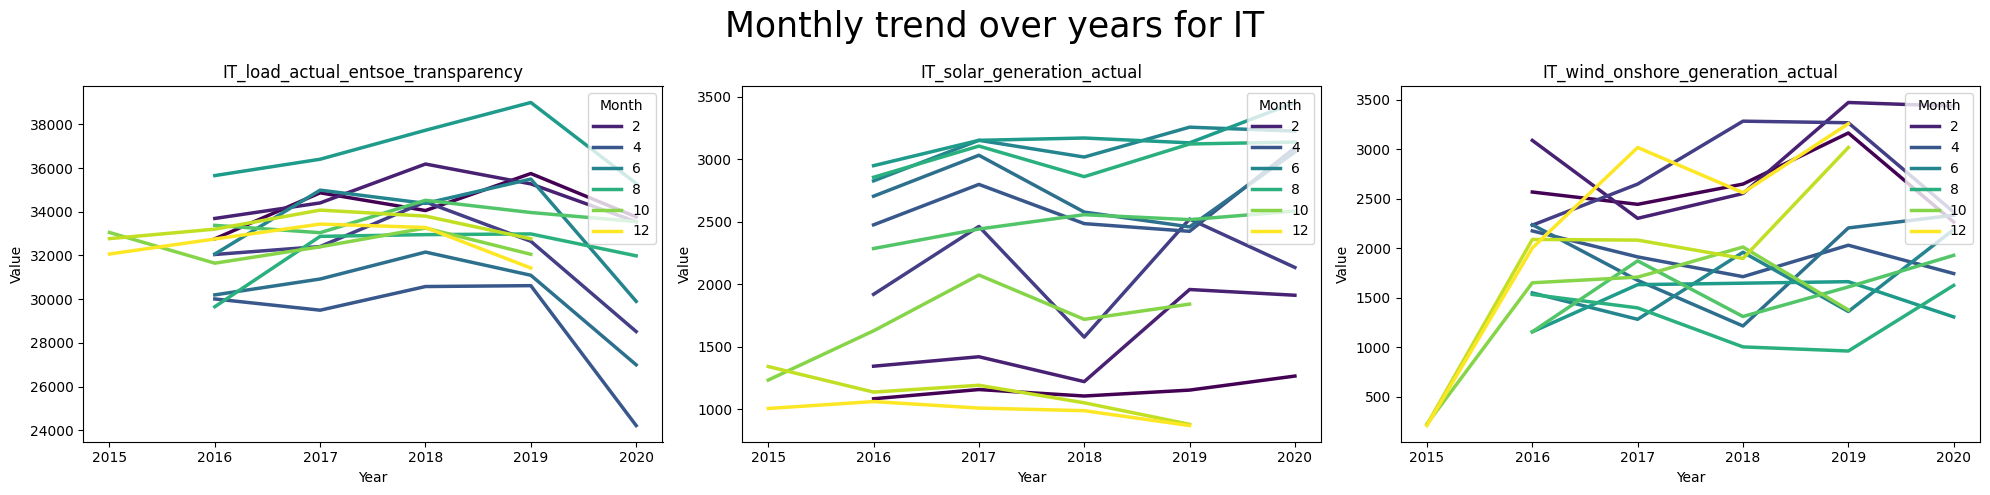

In [40]:
for col in top_5_countries:

    data = df_top_5.filter(like=col, axis=1)

    n_cols = len(data.columns)

    # append cols with date infos
    data = pd.concat([data, df_top_5.iloc[:, -6:]], axis=1)

    plot_seasonality(data = data, 
                     frequency='Year', 
                     hue='Month', 
                     num_cols=n_cols, 
                     title=f"Monthly trend over years for {col}")

Clear daily seasonality of load and solar generation. Therefore, it makes sence to use this parameter in ARIMA model.
Please note that we further will adjust UTC time to real time. The values are shifted 1-2 hours from current UTC time.

Though the different value ranges, we observe the consistency in patterns over all countries for load and solar generation.
The wind generation patterns differ accross all countries.

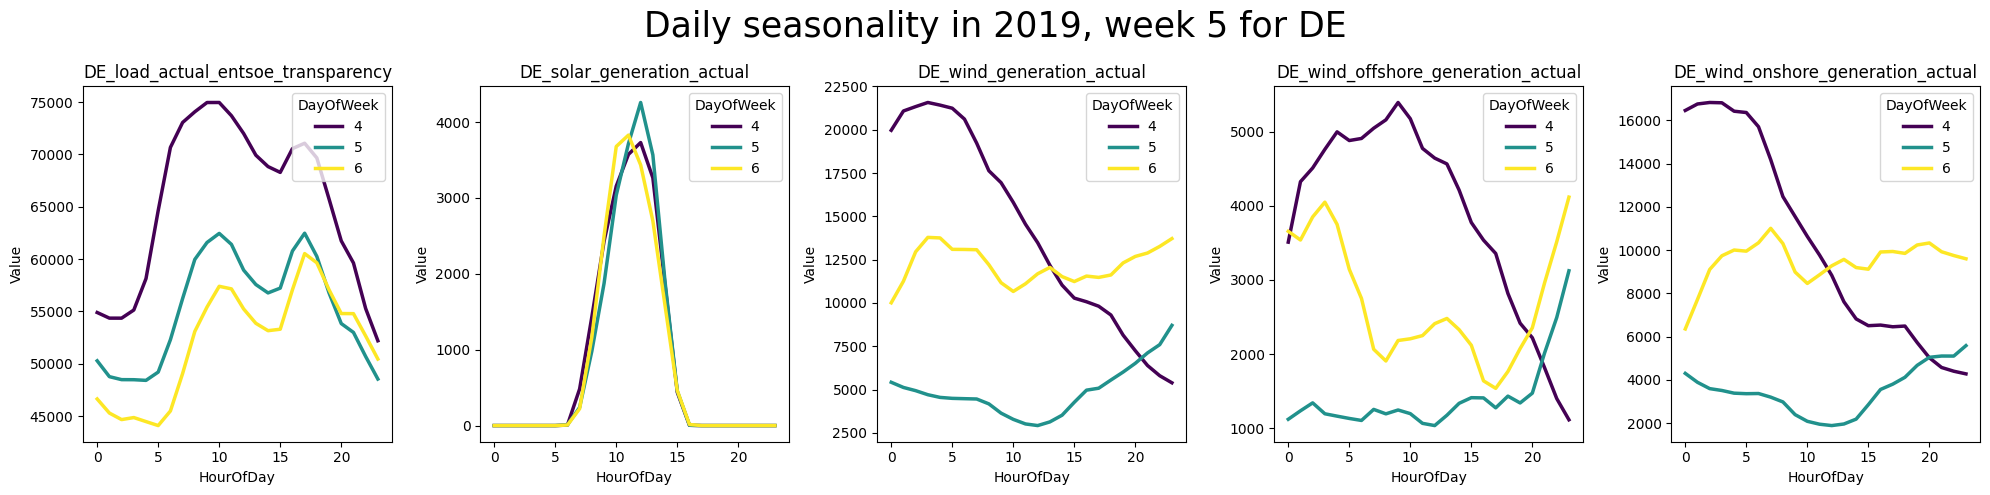

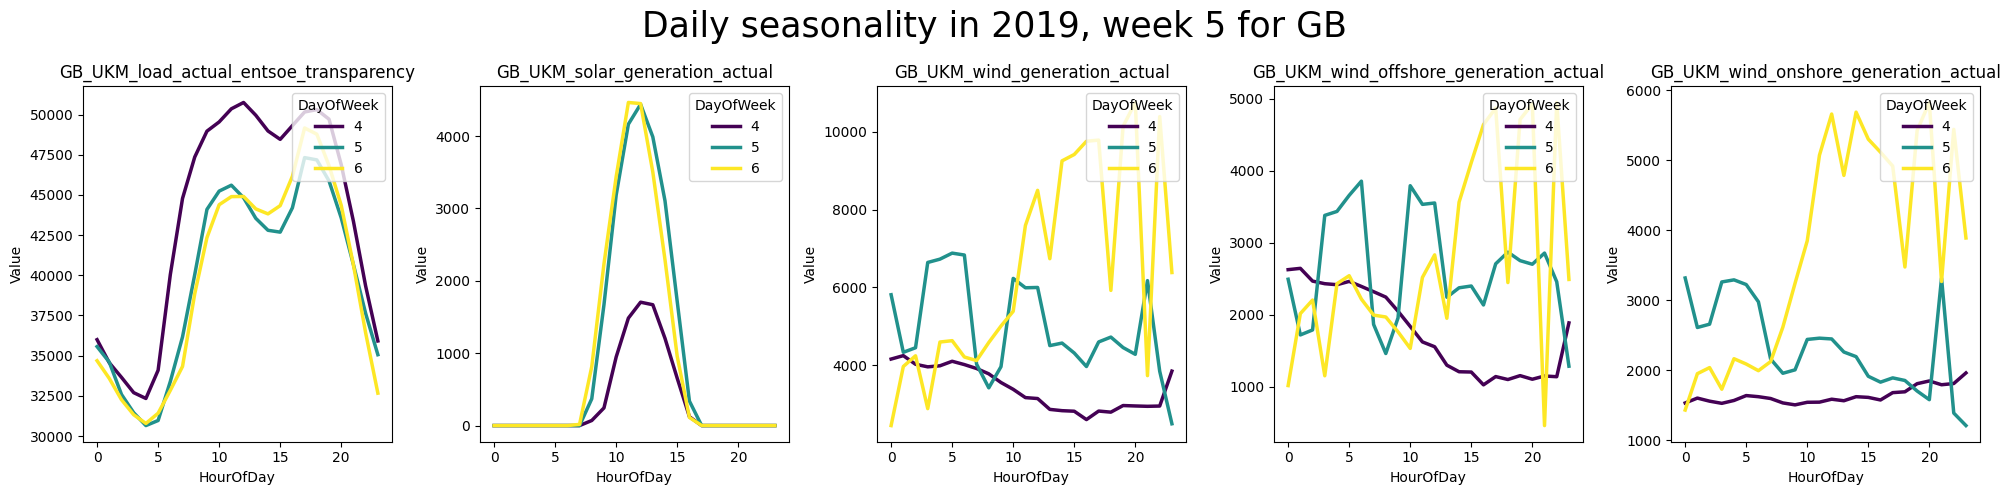

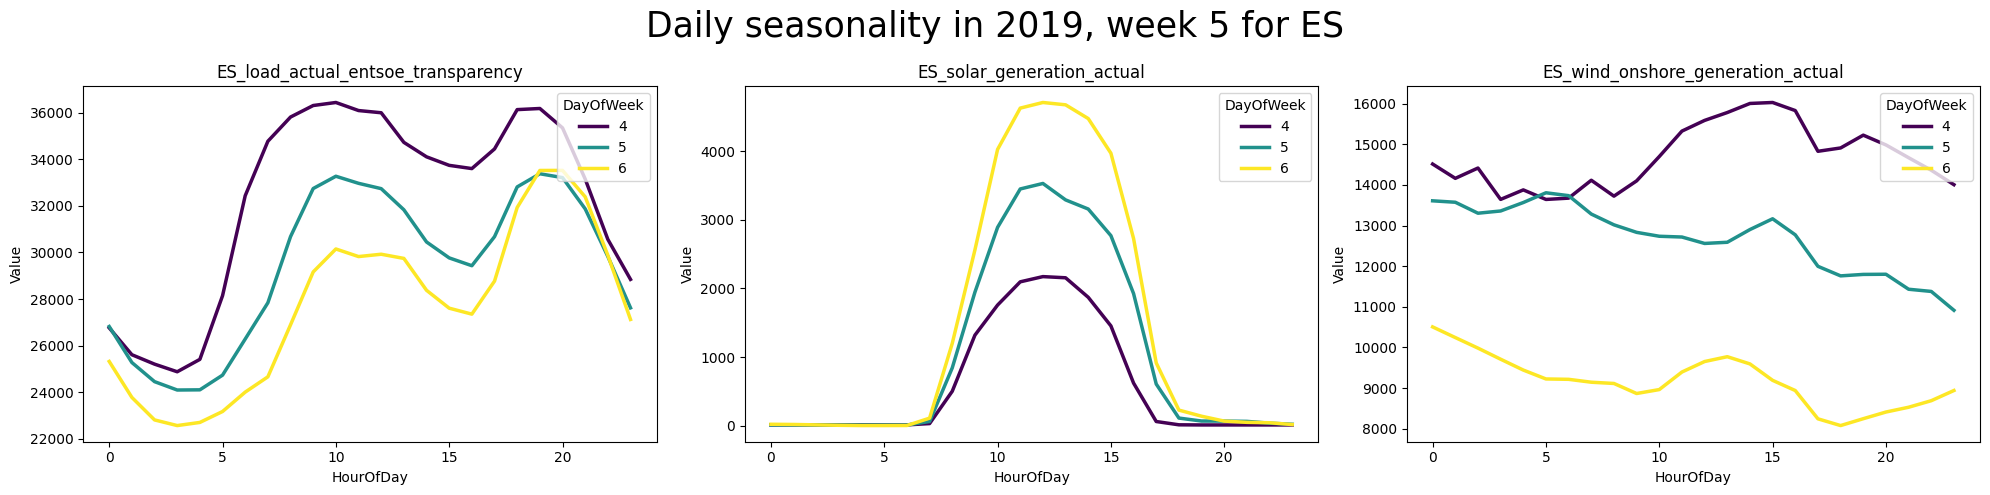

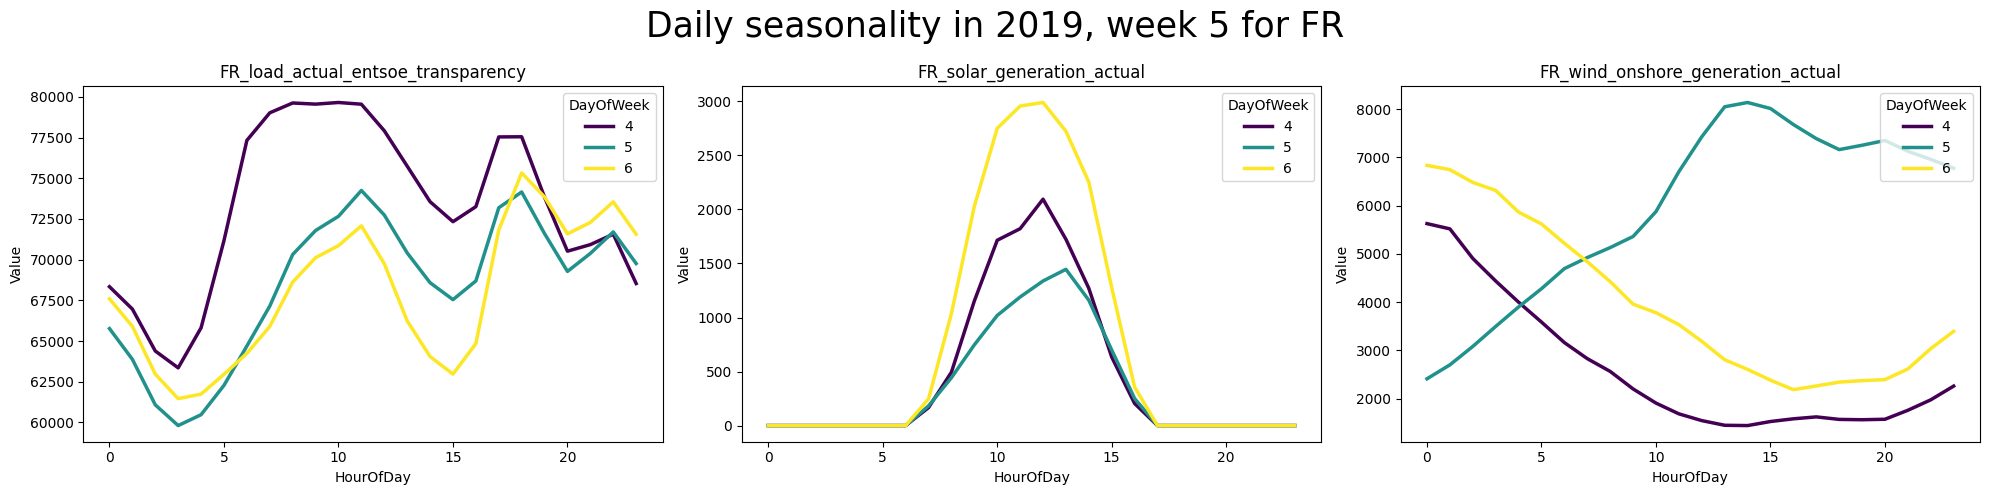

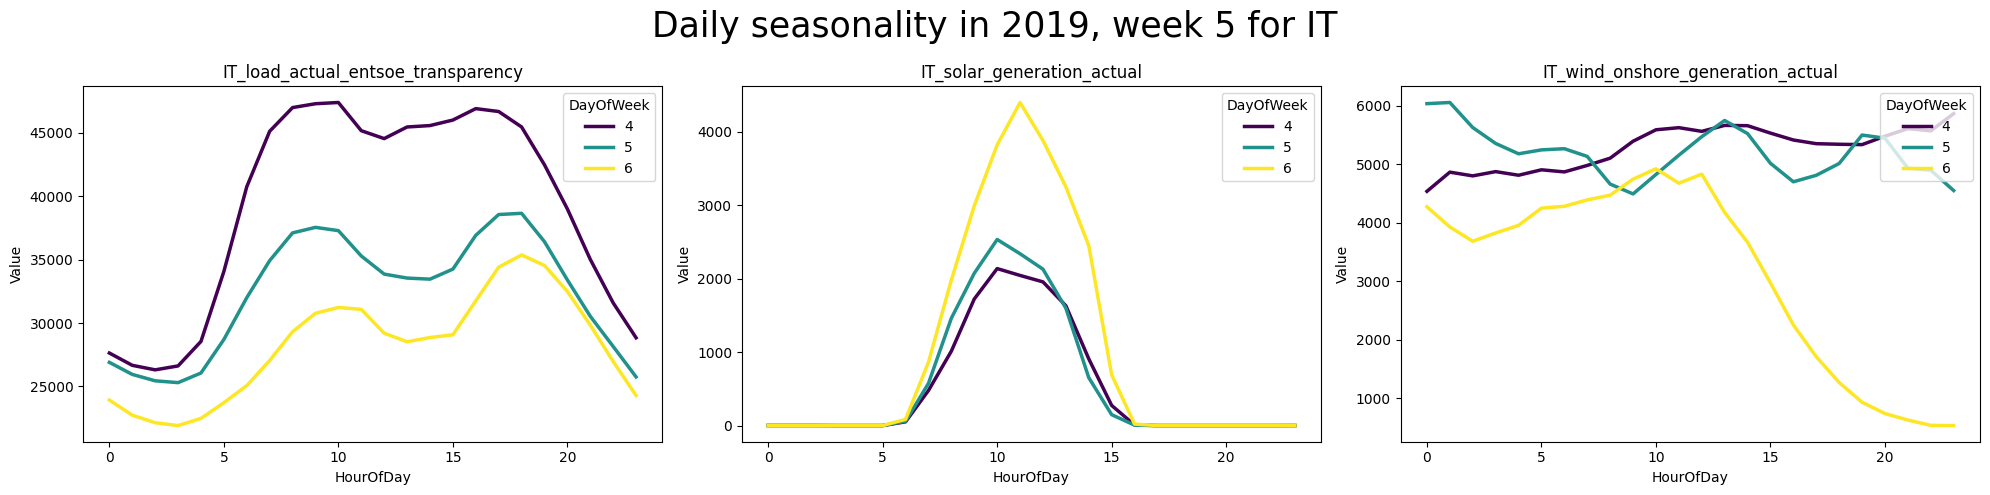

In [41]:
for col in top_5_countries:

    data = df_top_5.filter(like=col, axis=1)

    n_cols = len(data.columns)

    # append cols with date infos
    data = pd.concat([data, df_top_5.iloc[:, -6:]], axis=1)

    plot_seasonality(data=data[(data.index.year==2019) & 
                                (data.index.month==2) & 
                                (data.index.isocalendar().week==5)],
                     frequency='HourOfDay',
                     hue='DayOfWeek',
                     num_cols=n_cols,
                     title = f"Daily seasonality in 2019, week 5 for {col}")

Also, there is a weekly seasonality of load columns. It could be explained that there is more consumption of electricity during business days.
So, load has annual, weekly and daily seasonality. 

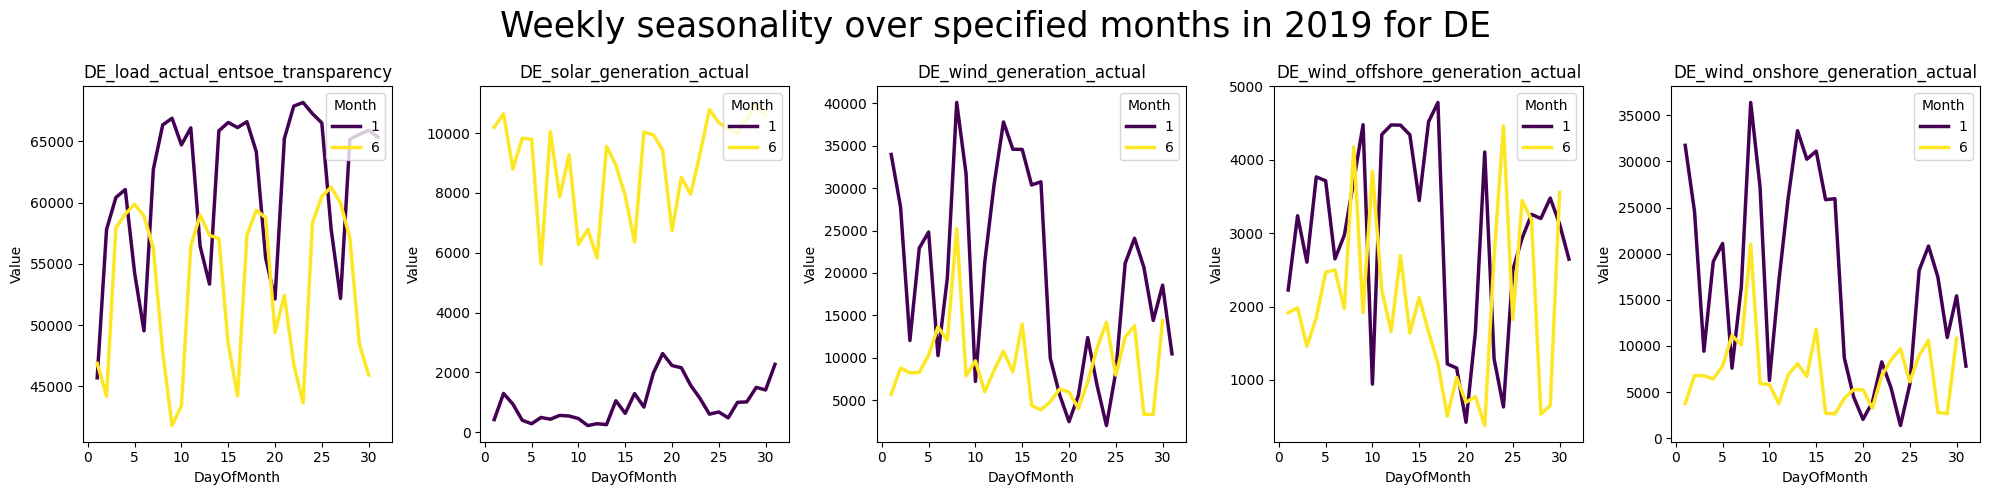

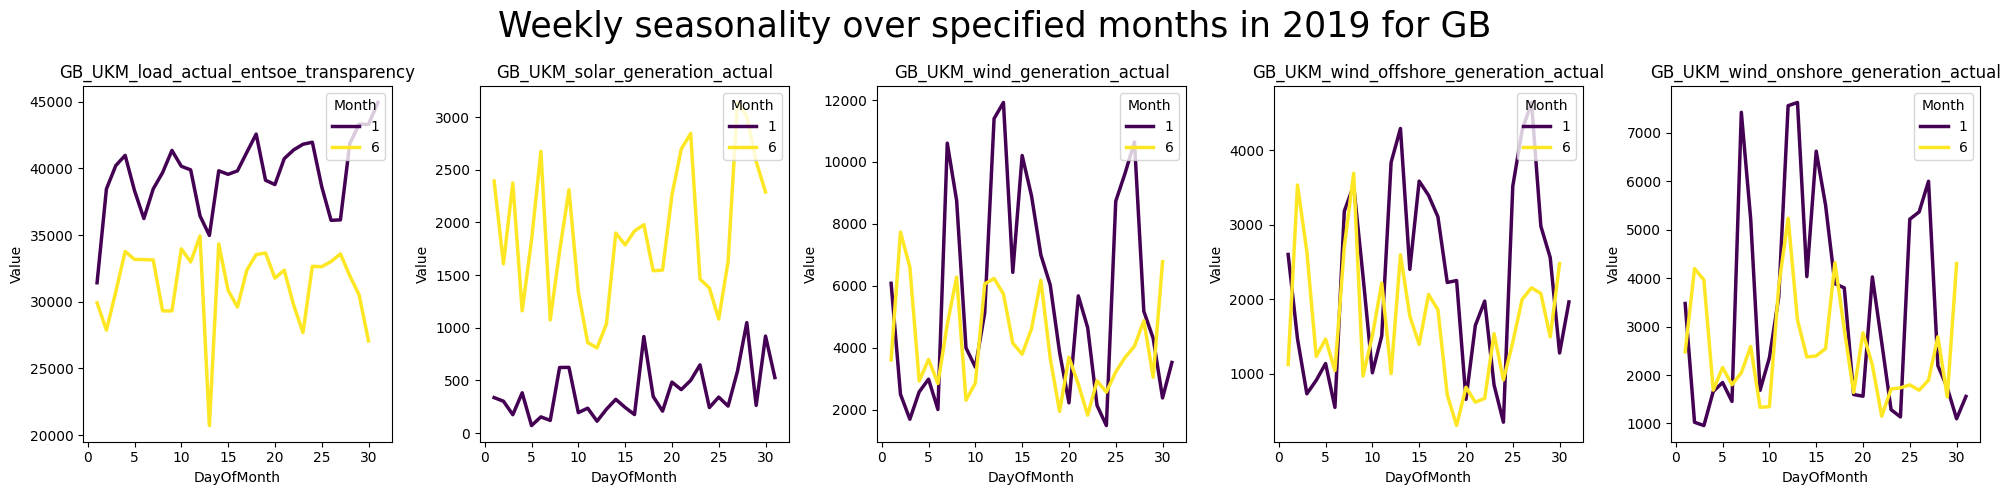

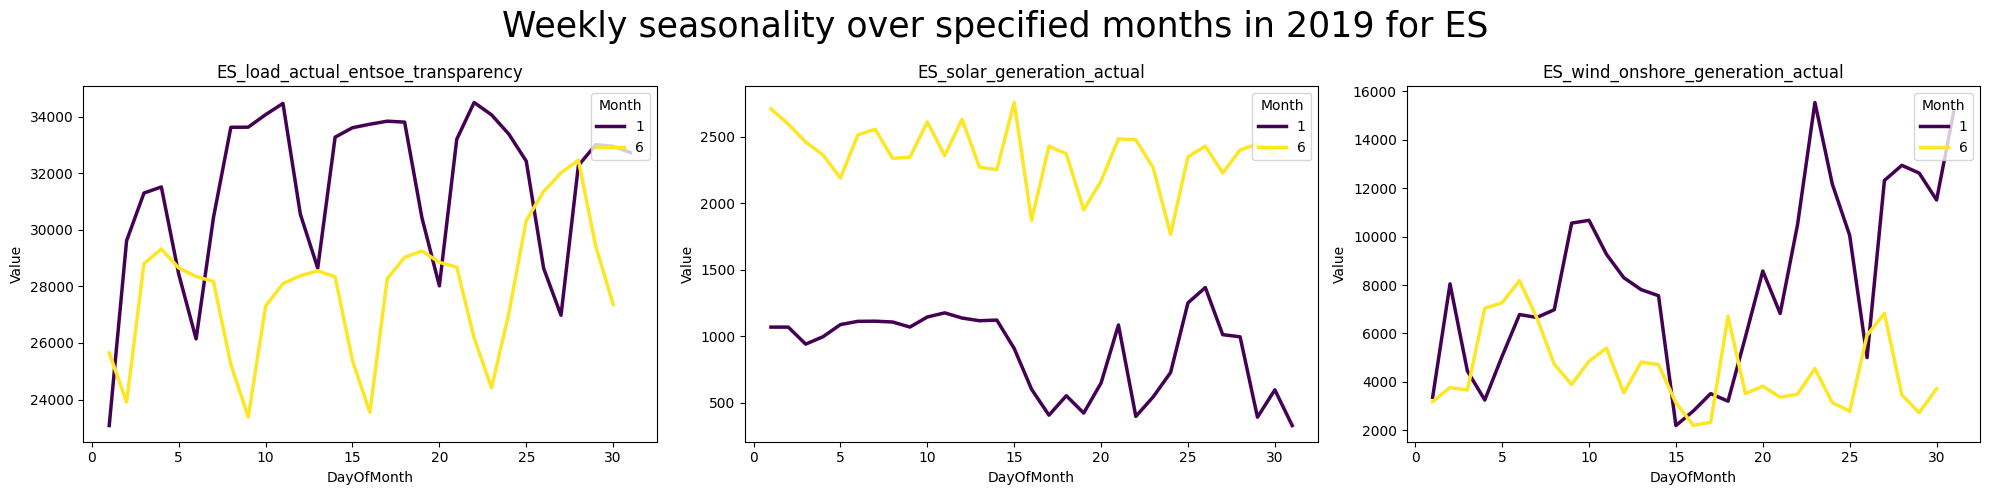

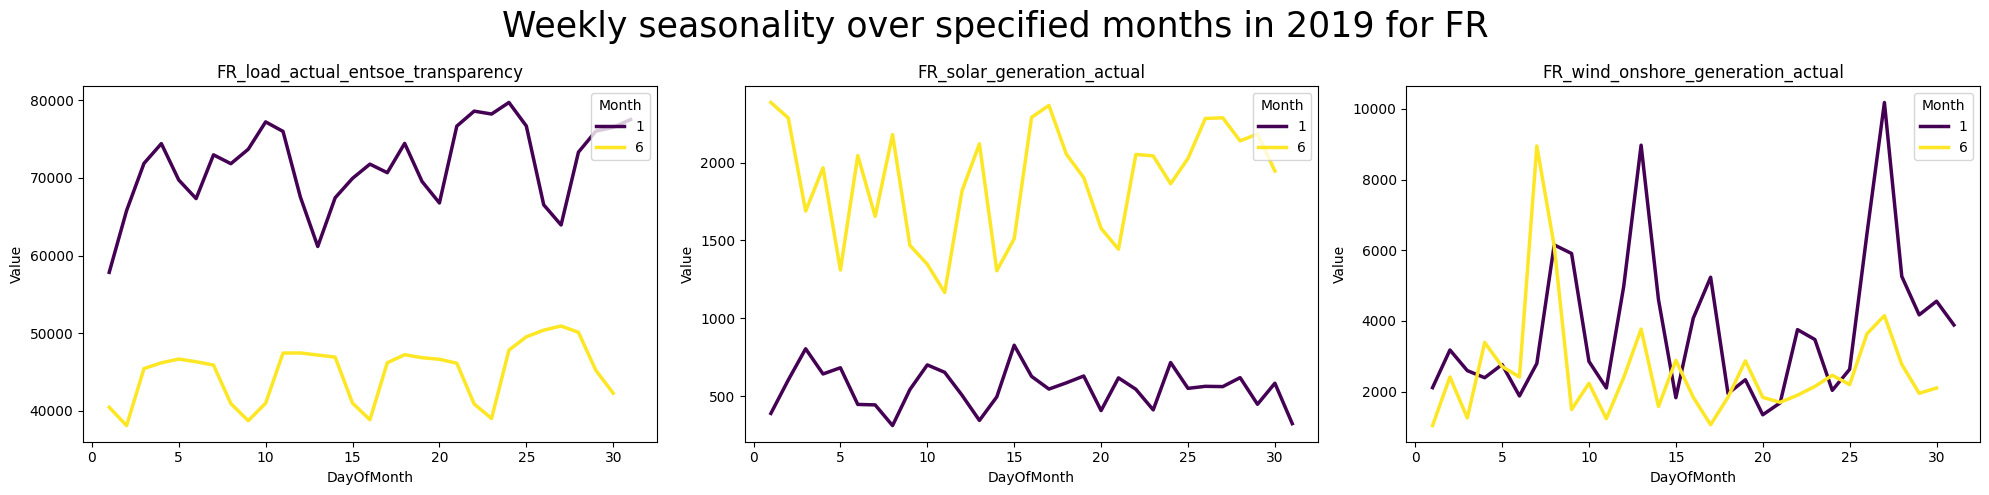

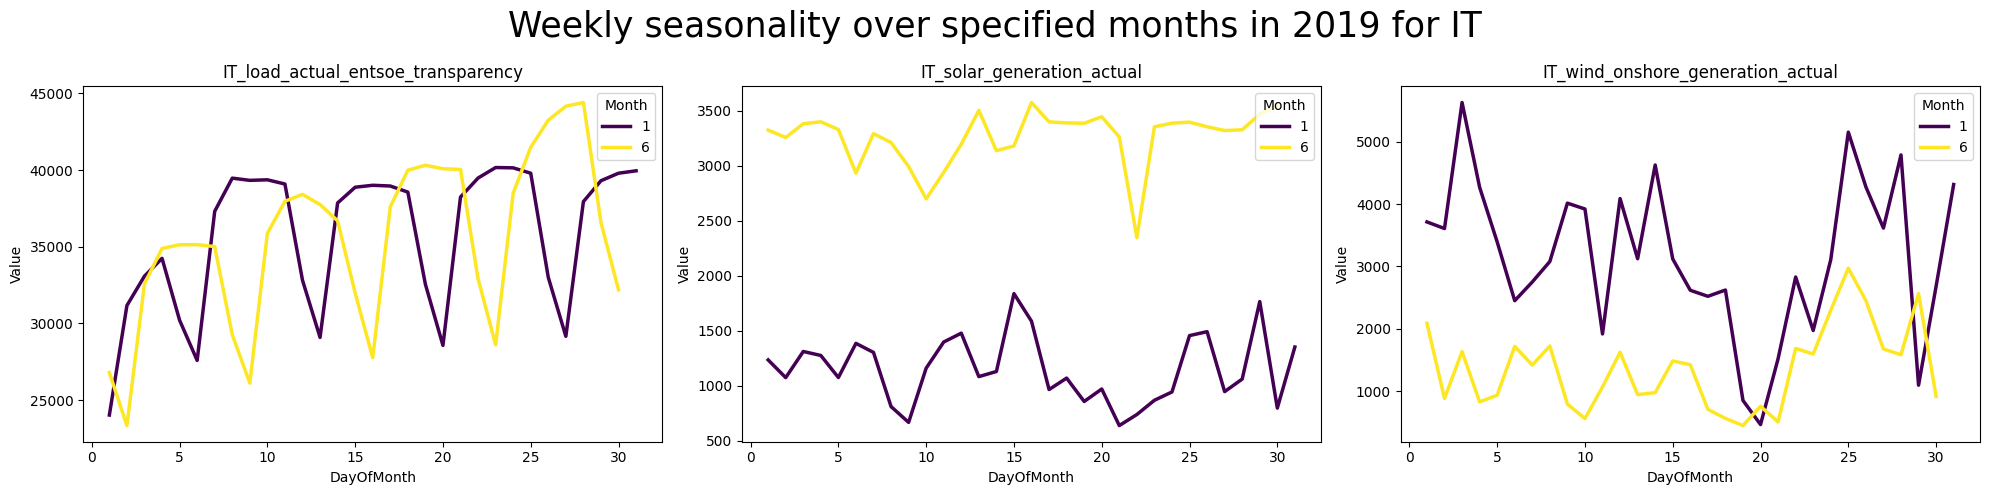

In [42]:
# Plot weekly seasonality for some months
# Only load has weekly seasonality
for col in top_5_countries:

    data = df_top_5.filter(like=col, axis=1)

    n_cols = len(data.columns)

    # append cols with date infos
    data = pd.concat([data, df_top_5.iloc[:, -6:]], axis=1)

    data = data[data.index.year == 2019]
    desired_months = [1, 6]
    data = data[data.index.month.isin(desired_months)]

    # Plot the seasonality for the desired months
    plot_seasonality(data=data, 
                     frequency='DayOfMonth', 
                     hue='Month',
                     num_cols=n_cols, 
                     title=f'Weekly seasonality over specified months in 2019 for {col}')

Here we have plots for values in each column. 

The data is not normally distributed. Some variables are skewed, such as "FR_wind_onshore_generation_actual" and "IT_wind_onshore_generation_actual". And others have multimodal distributions, as "DE_load_actual_entsoe_transparency" and "IT_load_actual_entsoe_transparency".

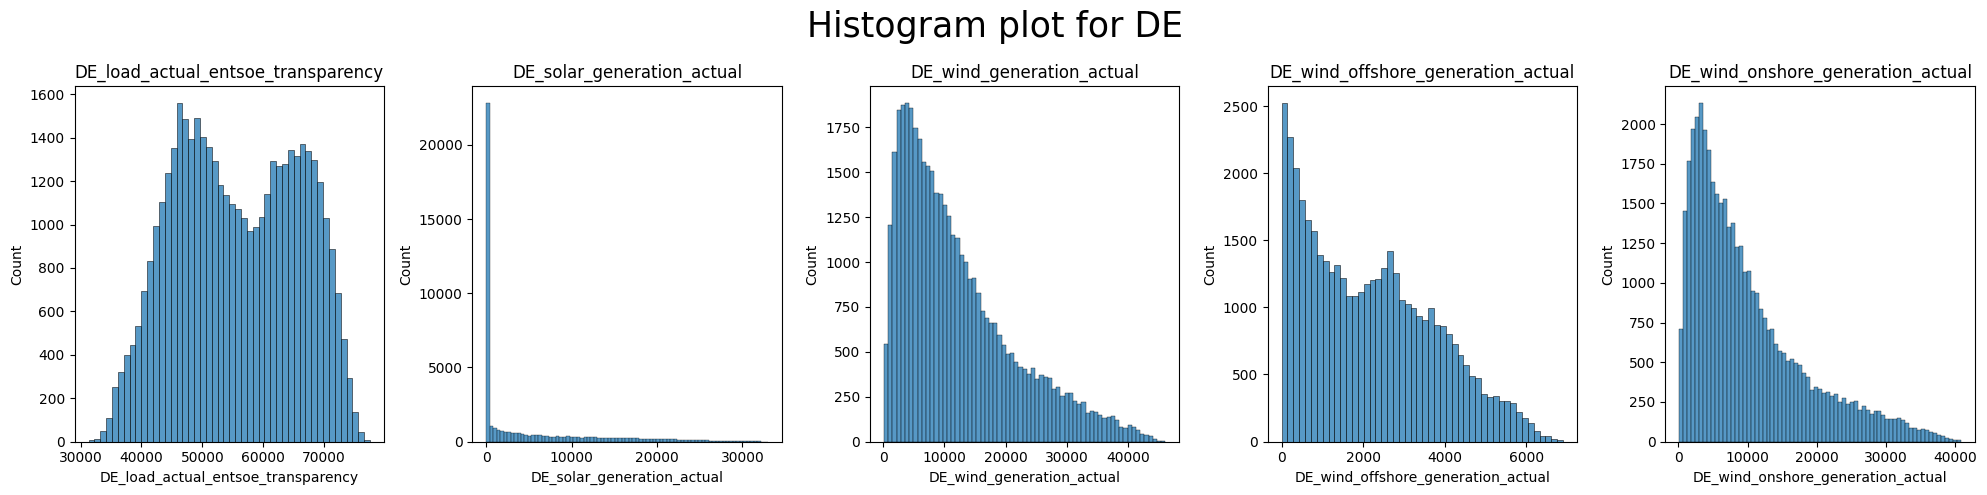

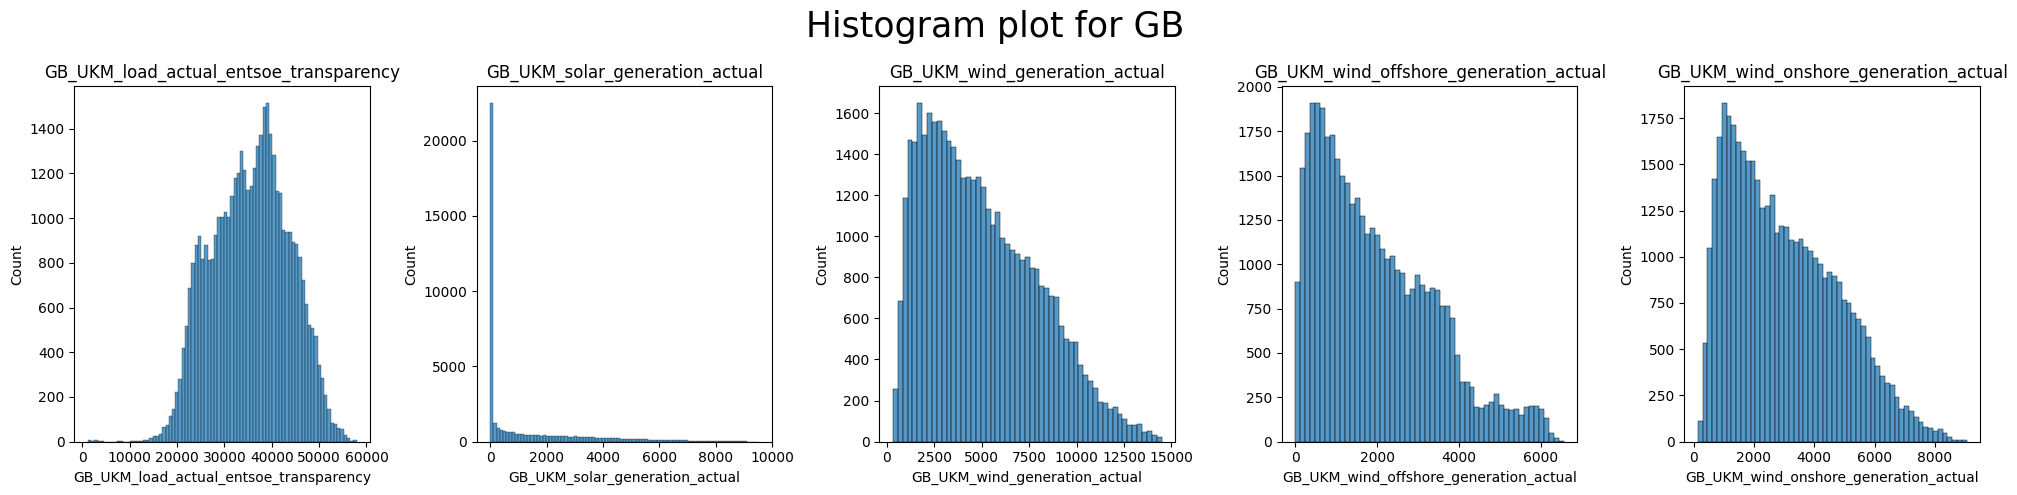

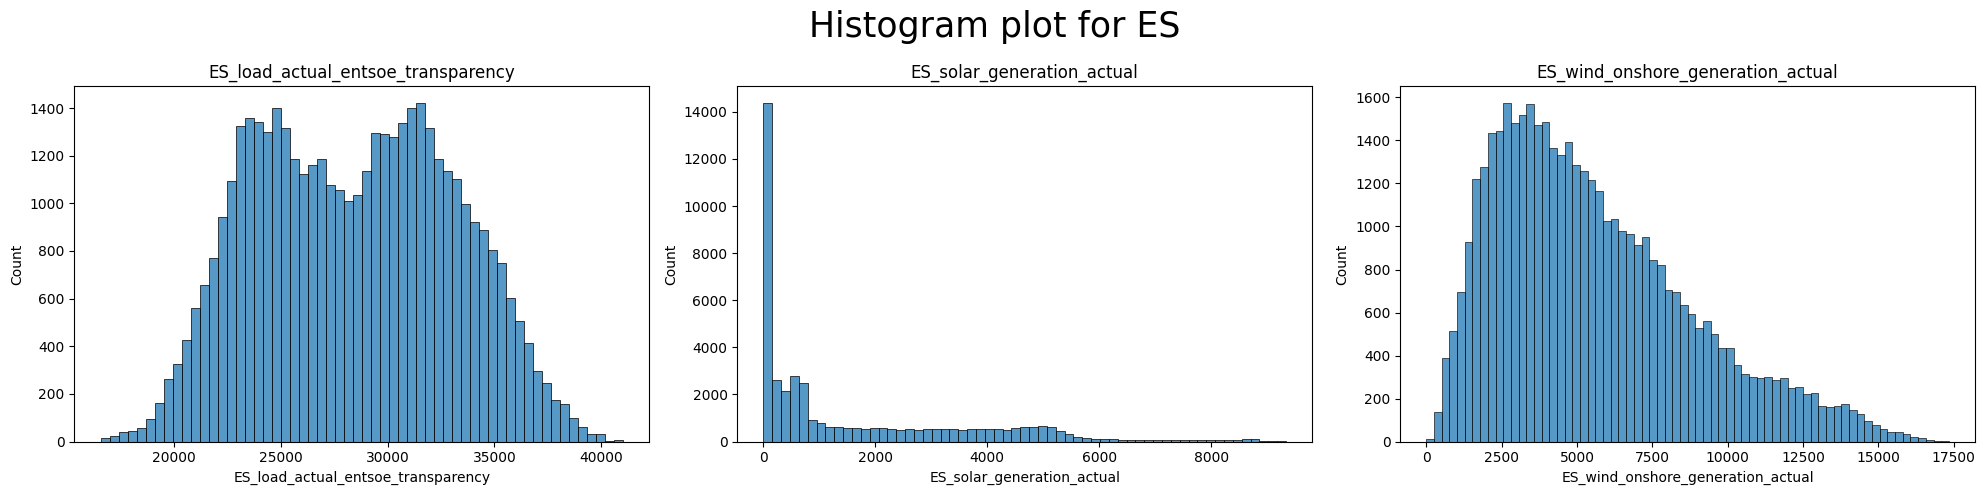

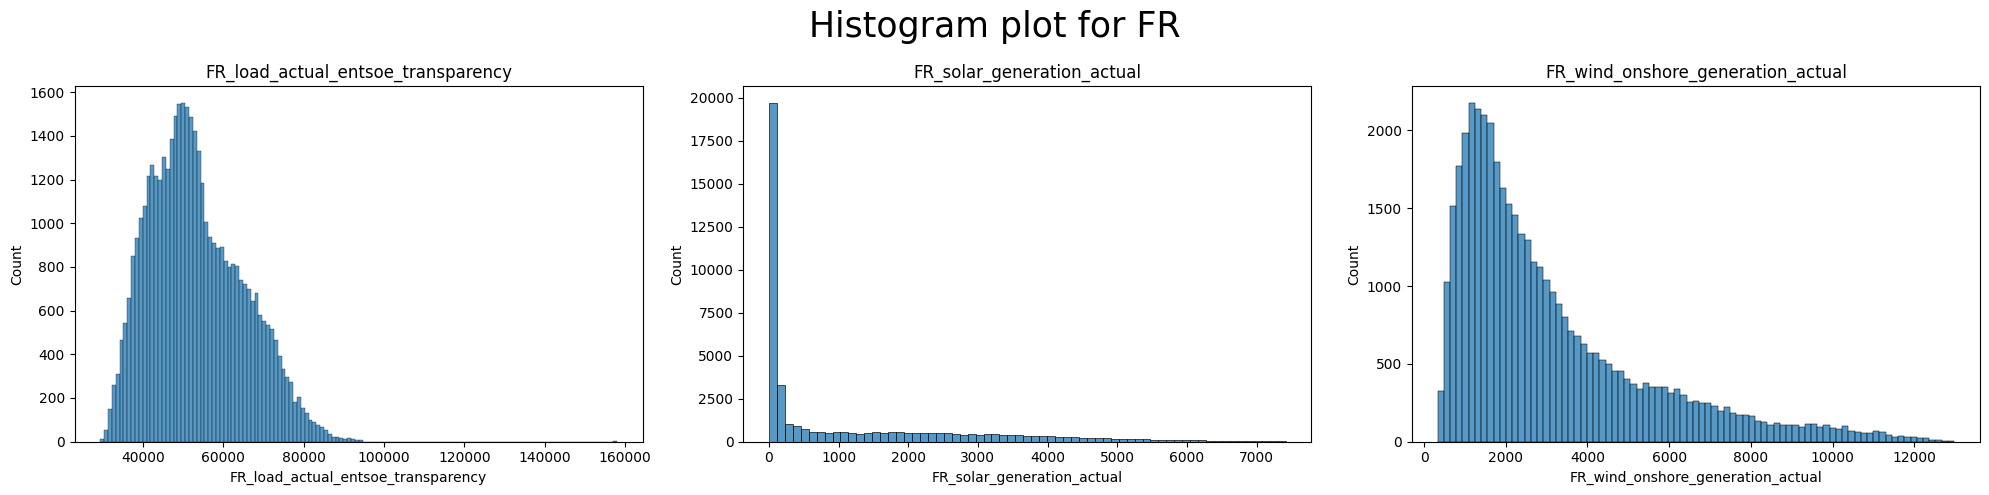

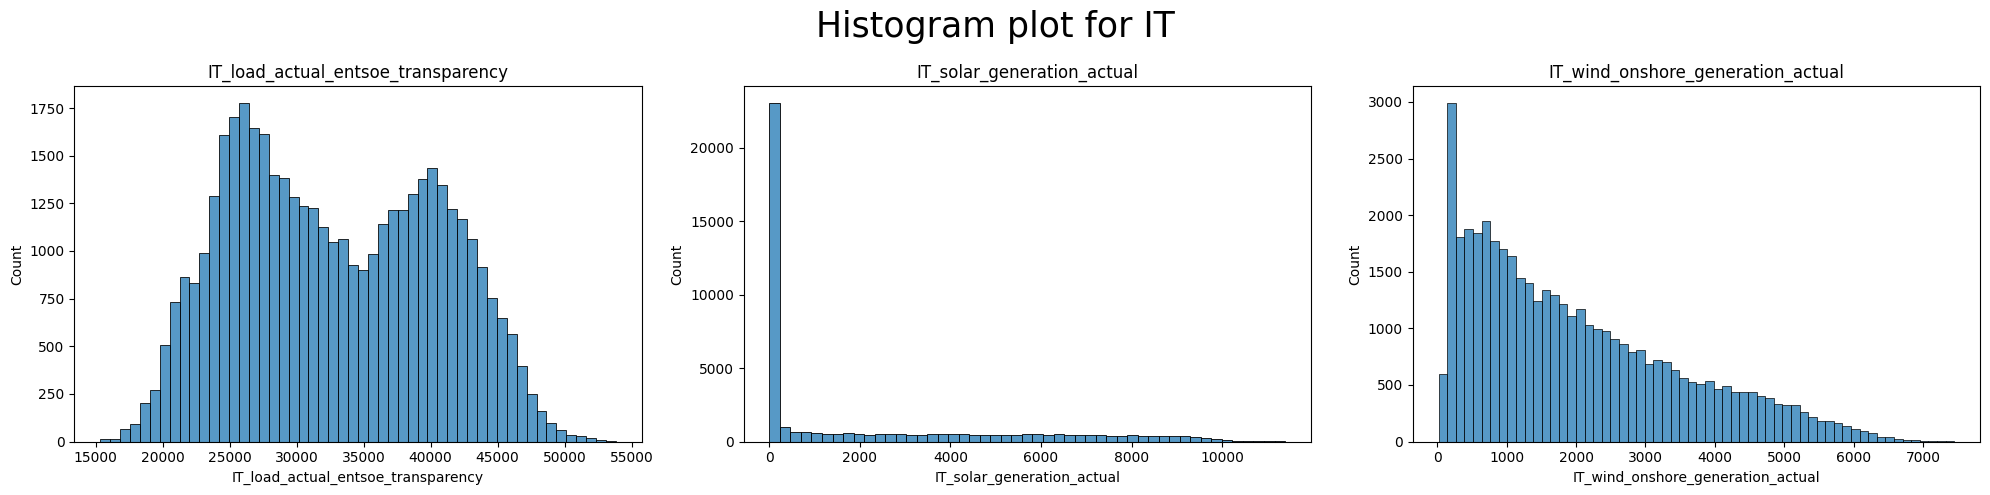

In [43]:
for col in top_5_countries: 

    data = df_top_5.filter(like=col, axis=1)

    n_cols = len(data.columns)
    
    hist_plots(data = data, col=col, num_cols=n_cols,
               title = f"Histogram plot for {col}")

Correlation between features.

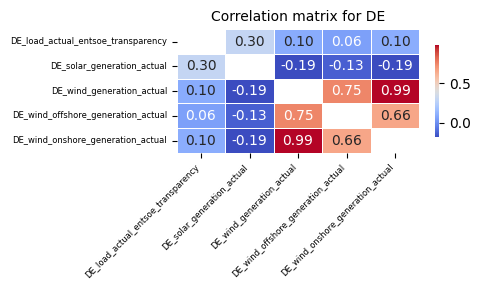

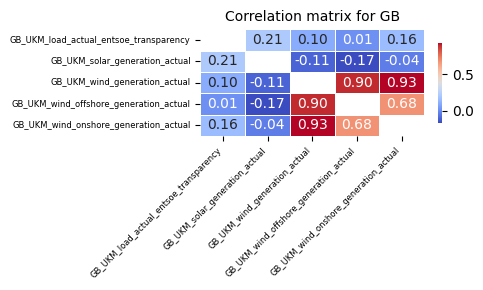

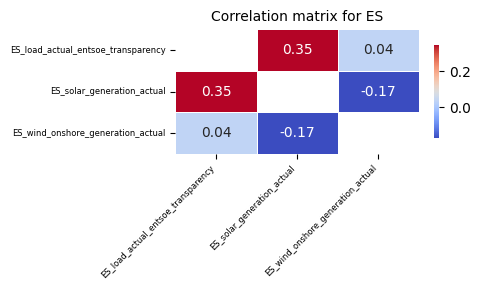

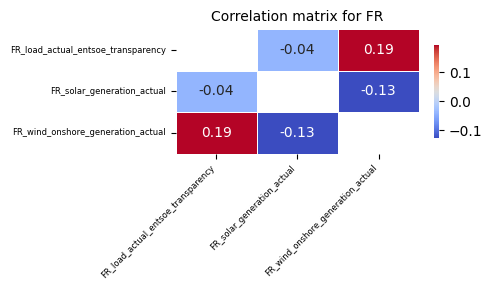

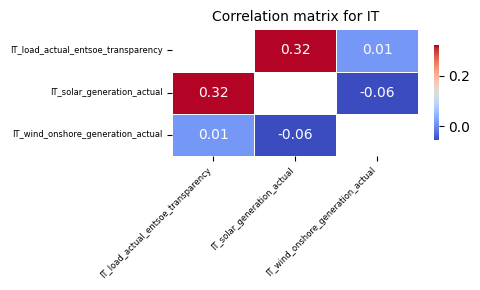

In [44]:
for country in top_5_countries:

    data = df_top_5.filter(like=country, axis=1)
    
    corr_plot(data = data,
              title = f"Correlation matrix for {country}")

# Outliers

In [45]:
print(f"{'Column name':<40} {'Number of outliers':>15} {'Percentage in dataset':>20}")
for col_name in df_top_5.select_dtypes(include='float').columns:
    count_outliers(df_top_5[col_name])

Column name                              Number of outliers Percentage in dataset
DE_load_actual_entsoe_transparency                     0                  0.0%
DE_solar_generation_actual                          3374                  7.8%
DE_wind_generation_actual                           1130                  2.6%
DE_wind_offshore_generation_actual                     0                  0.0%
DE_wind_onshore_generation_actual                   1688                  3.9%
ES_load_actual_entsoe_transparency                     0                  0.0%
ES_solar_generation_actual                           869                  2.0%
ES_wind_onshore_generation_actual                    555                  1.3%
FR_load_actual_entsoe_transparency                   113                  0.3%
FR_solar_generation_actual                          1395                  3.2%
FR_wind_onshore_generation_actual                   2224                  5.1%
GB_UKM_load_actual_entsoe_transparency           

In [46]:
for col_name in df_top_5.select_dtypes(include='float').columns:
    count_outliers(df_top_5[col_name], verbose=True)

Column name: 'DE_solar_generation_actual'
lower bound:      -10798.875,   upper bound:       17998.125
min value:               0.0,    max:                 32947.0
--------------------------------------------------------------------------------
Column name: 'DE_wind_generation_actual'
lower bound:        -13361.0,   upper bound:         35407.0
min value:             135.0,    max:                 46064.0
--------------------------------------------------------------------------------
Column name: 'DE_wind_onshore_generation_actual'
lower bound:      -11473.575,   upper bound:       29178.945
min value:             119.0,    max:                 40752.0
--------------------------------------------------------------------------------
Column name: 'ES_solar_generation_actual'
lower bound:         -4132.5,   upper bound:          7055.5
min value:               0.0,    max:                  9338.0
--------------------------------------------------------------------------------
Column nam

# AFC & PAFC plots

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(data, lags=100, alpha=0.05):
    """
    Plots ACF and PACF for a given time series data.

    Args:
        data (pd.Series): Time series data.
        lags (int): Number of lags to include in the plots.
    """
    # Create a figure with two subplots
    plt.figure(figsize=(16, 6))

    # Plot ACF
    plt.subplot(1, 2, 1)
    plot_acf(data, lags=lags, ax=plt.gca(), title='ACF Plot', alpha=0.05)
    plt.xlabel('Lags')
    plt.ylabel('ACF')

    # Plot PACF
    plt.subplot(1, 2, 2)
    plot_pacf(data, lags=lags, ax=plt.gca(), title='PACF Plot', alpha=0.05)
    plt.xlabel('Lags')
    plt.ylabel('PACF')

    plt.tight_layout()
    plt.show()

# Call the function
plot_acf_pacf(df_top_5['DE_load_actual_entsoe_transparency'][:500], lags=50, alpha=0.05)


In [ ]:
df_top_5

In [ ]:
plot_acf_pacf(df_top_5['DE_wind_offshore_generation_actual'][:500], lags=50, alpha=0.05)


In [ ]:
plot_acf_pacf(df_top_5['DE_solar_generation_actual'][:500], lags=50, alpha=0.05)


# Seasonality

In [ ]:
from statsmodels.tsa.seasonal import MSTL
mstl = MSTL(df_top_5["DE_load_actual_entsoe_transparency"][:20000], periods=(24, 24 * 7, 24 * 30, 24 * 365), stl_kwargs={"seasonal_deg": 0})
res = mstl.fit() 

In [ ]:
np.std(res.resid)

In [ ]:
np.std(res.seasonal.iloc[:, 0])

In [ ]:
np.std(res.seasonal.iloc[:, 1])

In [ ]:
np.std(res.seasonal.iloc[:, 2])

In [ ]:
np.std(res.seasonal.iloc[:, 3])

In [ ]:
fig.
res.observed.plot()

In [ ]:
residuals_df = pd.DataFrame()
df_country = df_top_5.filter(like='DE', axis=1)

for col in df_country.columns:
    #print(f"Column: {col}")
    mstl = MSTL(df_country[col], periods=(24, 24 * 7, 24 * 30, 24 * 365), stl_kwargs={"seasonal_deg": 0})
    res = mstl.fit()
    plot_seasonal_components(res, window_sizes, col)
    residuals_df[col] = res.resid


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Parameters for the time series
n_points = 10000  # Length of the time series
time_index = pd.date_range(start='2020-01-01', periods=n_points, freq='H')  # Hourly frequency

# Generate completely random data
#mega_random_series = np.random.random(n_points)  # Uniformly distributed random data
mega_random_series = np.arange(1, 10001)

# Create a DataFrame to hold the series
df_mega_random = pd.DataFrame({'Mega_Random_Series': mega_random_series}, index=time_index)

# Plot the series
plt.figure(figsize=(14, 8))
plt.plot(df_mega_random['Mega_Random_Series'], label='Mega Random Series', color='blue')
plt.title('Mega Random Time Series (Pure Random Data)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [ ]:
from statsmodels.tsa.seasonal import MSTL
mstl_3 = MSTL(df_mega_random["Mega_Random_Series"], periods=(24, 24 * 7), stl_kwargs={"seasonal_deg": 0})
res_3 = mstl_3.fit() 

In [ ]:
fig = plt.figure(figsize=(6, 6))
plt.plot(res_3.seasonal.iloc[:24*4, 0])
plt.plot(res_3.seasonal.iloc[:24*4, 0].rolling(window=12, center=True).mean(), color='red', linewidth=2, label="Smoothed")

In [ ]:
fig = plt.figure(figsize=(6, 6))
plt.plot(res_3.seasonal.iloc[:24*14, 1])
plt.plot(res_3.seasonal.iloc[:24*14, 1].rolling(window=60, center=True).mean(), color='red', linewidth=2, label="Smoothed")

In [ ]:
np.std(res_3.seasonal.iloc[:, 1])

In [ ]:
np.std(res_3.seasonal.iloc[:, 0])

In [ ]:
np.std(res_3.resid)

In [ ]:
from scipy.signal import periodogram

def plot_periodogram(data):
    freqs, psd = periodogram(data)
    plt.figure(figsize=(10, 6))
    plt.plot(1/freqs, psd)
    plt.xscale('log')
    plt.xlabel('Period (log scale)')
    plt.ylabel('Power Spectral Density')
    plt.title('Periodogram')
    plt.show()

# Example usage
plot_periodogram(df_top_5['DE_load_actual_entsoe_transparency'].values)

In [ ]:
import matplotlib.pyplot as plt

def plot_seasonal_components(res, window_sizes, col_name):
    """
    Plots trend and seasonal components of a time series using the MSTL decomposition.

    Args:
        res (object): The result object from MSTL decomposition containing 
                      trend and seasonal components.
        window_sizes (dict): A dictionary containing the rolling window sizes 
                            for smoothing each component.
        col_name (str): The name of the column to be processed.
    """
    components = {
        'Actual': res.observed,
        'Trend': res.trend,
        'Daily Seasonality': res.seasonal.iloc[:24*7, 0],
        'Weekly Seasonality': res.seasonal.iloc[:24*7*5, 1],
        'Monthly Seasonality': res.seasonal.iloc[:24*30*4, 2],
        'Yearly Seasonality': res.seasonal.iloc[:, 3],
    }

    # Define date ranges for x-axis ticks
    date_ranges = {
        'Daily Seasonality': pd.date_range(start=res.seasonal.index[0], periods=7, freq="D"),  # 7 days for daily
        'Weekly Seasonality': pd.date_range(start=res.seasonal.index[0], periods=5, freq="W"),  # 5 weeks for weekly
        'Monthly Seasonality': pd.date_range(start=res.seasonal.index[0], periods=4, freq="M"),  # 4 months for monthly
        'Yearly Seasonality': pd.date_range(start=res.seasonal.index[0], periods=5, freq="Y"),  # 5 years for yearly
    }

    plt.figure(figsize=(16, 16))
    
    for i, (title, component) in enumerate(components.items(), start=1):
        plt.subplot(6, 1, i)
        plt.plot(component, label=title)
        plt.title(title)
        if title != "Trend":
            plt.xticks(date_ranges[title])
        #if title in ['Monthly Seasonality', 'Yearly Seasonality']:
            plt.plot(component.rolling(window=window_sizes[title], center=True).mean(), color='red', linewidth=2, label="Smoothed")
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.legend(loc='lower right')#, bbox_to_anchor=(1, 0.5))
    plt.suptitle(f'Time Series Decomposition of {col_name}', fontsize=20)    
    plt.tight_layout()
    plt.show()

window_sizes = {
    'Daily Seasonality': 12,  # Smoother daily seasonality
    'Weekly Seasonality': 48,  # Smoother weekly seasonality
    'Monthly Seasonality': 180,  # Smoother monthly seasonality
    'Yearly Seasonality': 1440,  # Smoother yearly seasonality
}

plot_seasonal_components(res, window_sizes, 'DE')


In [ ]:
mstl_2 = MSTL(df_top_5["DE_wind_offshore_generation_actual"], periods=(24, 24 * 7, 24 * 30, 24 * 365), stl_kwargs={"seasonal_deg": 0})
res_2 = mstl_2.fit() 

In [ ]:
plot_seasonal_components(res_2, window_sizes)

In [ ]:
res.resid

In [ ]:
res_2.resid

In [ ]:
from pmdarima.arima.utils import ndiffs, nsdiffs

def stationary_seasonal(data, column_name):
    """
    Function that checks stationarity of a time series and 
    whether seasonal differencing is required or not.

    Args:
        data (pd.DataFrame): Dataframe with time series data.
        column_name (str): The name of the column in the dataframe.
    """
    # https://alkaline-ml.com/pmdarima/1.3.0/tips_and_tricks.html?highlight=kpss
    # https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

    # unit root, trend
    adf_diff = ndiffs(data, test='adf')

    # difference stationary
    kpss_diff = ndiffs(data, test='kpss')

    print(f'Column name: {column_name}')

    
    if adf_diff == 0:
        print('ADF: Is stationary.')
    else: 
        print('ADF:Is not stationary.')
        print('adf_diff', adf_diff)

    if kpss_diff == 0:
        print('KPSS: Is stationary.')
    else: 
        print('KPSS: Is not stationary.')
        print('kpss_diff', kpss_diff)

    # unit root
    ocsb_diff = nsdiffs(data, test='ocsb', m=24, max_D=5)
    # more sensitive, can find seasonality if there are complex or less pronounced patterns
    ch_diff = nsdiffs(data, test='ch', m=24, max_D=5)
    seasonal_diff = max(ocsb_diff, ch_diff)

    if seasonal_diff == 0:
        print('Does not require seasonal differencing')
    else:
        print('Requires seasonal differencing')
        print('ocsb_diff', ocsb_diff, 'ch_diff', ch_diff)
    print('-'*50)
    return column_name if seasonal_diff != 0 else None


In [ ]:
stationary_seasonal(res.resid, "DE_load_actual_entsoe_transparency")

In [ ]:
stationary_seasonal(res_2.resid, "DE_wind_offshore_generation_actual")

In [ ]:
import statsmodels.api as sm
def granger_causality(col1: pd.Series, 
                      col2: pd.Series,
                      test: str='ssr_ftest',
                      max_lag: int=12) -> None:
    """
    Performs Granger causality test for a time serie from col1 and col2.

    Args:
        data (pd.DataFrame): The input data as a pandas DataFrame.
        col1 (pd.Series): The name of the first time serie.
        col2 (str): The name of the second time serie.
        test (str): The type of Granger causality test to perform.
                    Possible alternatives are: 'ssr_ftest', 'ssr_chi2test', 'lrtest', 
                    'params_ftest' (default: 'ssr_ftest').
        max_lag (int): The maximum lag order to consider (default: 12).

    Returns:
        None
    """

    results = sm.tsa.stattools.grangercausalitytests(pd.concat([col1, col2], axis=1),
                                                     maxlag=max_lag, 
                                                     verbose=False)
    
    #print(f"'{col1}' -> '{col2}':")
    
    
    important_lags = [lag for lag in range(1, max_lag+1) if results[lag][0][test][1] < 0.05]

    if len(important_lags) == 0:
        print("No important lags found.")
    else:
        print(f"Important lags up to lag {max_lag}: {important_lags} \n")
    
    return None

granger_causality(res.resid, res_2.resid)

# Test for stationarity

The following section checks our data in pursuit of stationarity and interrelationships between variables. 
First we determine each time serie for stationarity, namely does it require trend or seasonal differencing.
Then, we apply Granger causality test to find whether one time serie past values are beneficial to predict another.

We performed tests, like Augmented Dickey-Fuller (ADF) and Kwiatkowski-Phillips-Schmidt-Shin (KPSS), to check for trend stationarity. And OCSB and CHTest for seasonality. As we can see, all series exhibit non-stationarity. Most wind-related series do not have seasonality. We decided on use of the pmdarima package, because of its functionality. The combination of tests is preferred due to package description (statsmodel package advises the same).

In [ ]:
from pmdarima.arima.utils import ndiffs, nsdiffs

def stationary_seasonal(data, column_name):
    """
    Function that checks stationarity of a time series and 
    whether seasonal differencing is required or not.

    Args:
        data (pd.DataFrame): Dataframe with time series data.
        column_name (str): The name of the column in the dataframe.
    """
    # https://alkaline-ml.com/pmdarima/1.3.0/tips_and_tricks.html?highlight=kpss
    # https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

    # unit root, trend
    adf_diff = ndiffs(data[column_name], test='adf')

    # difference stationary
    kpss_diff = ndiffs(data[column_name], test='kpss')

    print(f'Column name: {column_name}')

    
    if adf_diff == 0:
        print('ADF: Is stationary.')
    else: 
        print('ADF:Is not stationary.')
        print('adf_diff', adf_diff)

    if kpss_diff == 0:
        print('KPSS: Is stationary.')
    else: 
        print('KPSS: Is not stationary.')
        print('kpss_diff', kpss_diff)

    # unit root
    ocsb_diff = nsdiffs(data[column_name], test='ocsb', m=24, max_D=5)
    # more sensitive, can find seasonality if there are complex or less pronounced patterns
    ch_diff = nsdiffs(data[column_name], test='ch', m=24, max_D=5)
    seasonal_diff = max(ocsb_diff, ch_diff)

    if seasonal_diff == 0:
        print('Does not require seasonal differencing')
    else:
        print('Requires seasonal differencing')
        print('ocsb_diff', ocsb_diff, 'ch_diff', ch_diff)
    print('-'*50)
    return column_name if seasonal_diff != 0 else None


In [ ]:
seas = list()

for col_name in df_top_5.select_dtypes(include='float').columns:
    seasonal = stationary_seasonal(df_top_5, col_name)
    seas.append(seasonal) if seasonal is not None else None

In [ ]:
seas

# Granger causality

We first need to perform differencing. We first perform seasonal differencing. After that, we have already achieved stationary columns and do not need to perform trend differencing on them.


In [ ]:
# Seasonal differencing
data_seasonal_diff = df_top_5[seas].diff(periods=24).dropna()

for col in data_seasonal_diff.columns:
    print(f'Column name: {col}:')
    kpss_diff = ndiffs(data_seasonal_diff[col], test='kpss')
    ch_diff = nsdiffs(data_seasonal_diff[col], test='ch', m=24, max_D=5)
    print('kpss:', kpss_diff, 'ch:', ch_diff)

Perform trend differencing on the remaining columns.

In [ ]:
remain_cols = list(filter(lambda x: x not in seas, df_top_5.columns))
remain_cols

In [ ]:
# First difference
data_diff = df_top_5[['DE_wind_generation_actual',
 'DE_wind_offshore_generation_actual',
 'DE_wind_onshore_generation_actual',
 'ES_wind_onshore_generation_actual',
 'FR_wind_onshore_generation_actual']].diff().dropna()

for col in data_diff.columns:
    print(f'Column name: {col}:')
    kpss_diff = ndiffs(data_diff[col], test='kpss')
    print('kpss:', kpss_diff)

In [ ]:
# Merge all differenced columns
full_diff = pd.merge(data_diff, data_seasonal_diff, right_index=True, left_index=True)

Perform Granger causality test for each combination of columns. Granger causality finds linear relationships, as it uses OLS.
We have to perform test for col1 & col2 and for col2 & col1. Granger causality is not symmetric. If col2 Granger causes col1, we cannot automatically conclude that col1 causes col2.


In [ ]:
for country in ['DE', 'ES', 'FR', 'GB_UKM']:

    df_country = full_diff.filter(like=country, axis=1)
    col_combinations = list(permutations(df_country.columns, 2))
    print(f'Country: {country}')

    for pair in range(len(col_combinations)):
        granger_causality(df_country, col_combinations[pair][0], col_combinations[pair][1])

    print('-'*80)

In [ ]:
from statsmodels.tsa.stattools import coint

# Perform Engle-Granger Cointegration Test
score, p_value, _ = coint(df_top_5['DE_solar_generation_actual'], df_top_5['DE_load_actual_entsoe_transparency'])
print(f'Cointegration Test p-value: {p_value}')